# Graph embeddings

This notebook can be used to obtain different embeddings for a provided input graph using different node embedding models such as ARGAE, GAE and Node2Vec.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia, Planetoid, KarateClub
from torch_geometric.nn import GAE, GCNConv, Sequential, InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import umap
import umap.plot
import scanpy as sc
from scipy.stats import spearmanr, pearsonr

sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def process_single_epoch(
    model,
    data,
    node_feature_key,
    mode,
    optimizer,
    edge_weight_key=None,
    reconstruct_features=False,
):
    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        # Negative edges created via negative sampling
        if reconstruct_features:
            loss = model.recon_loss(inputs, latents, data.pos_edge_label_index)
        else:
            loss = model.recon_loss(latents, data.pos_edge_label_index)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            latents = model.encode(
                inputs,
                data.edge_index,
                edge_weight=edge_weight,
            )
            if reconstruct_features:
                loss = model.recon_loss(inputs, latents, data.pos_edge_label_index)
            else:
                loss = model.recon_loss(latents, data.pos_edge_label_index)

    return loss.item()


def test_gae(model, data, node_feature_key, edge_weight_key=None):
    model.eval()
    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    latents = model.encode(
        inputs,
        data.edge_index,
        edge_weight=edge_weight,
    )
    auc, ap = model.test(
        latents,
        data.pos_edge_label_index,
        data.neg_edge_label_index,
    )
    return auc, ap


def train_gae(
    model,
    data_dict,
    node_feature_key,
    optimizer,
    n_epochs=500,
    early_stopping=20,
    edge_weight_key=None,
    reconstruct_features=False,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.device = device
    print("Using {}".format(device))
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                data = data_dict[mode].to(device)
                loss = process_single_epoch(
                    model=model,
                    data=data,
                    node_feature_key=node_feature_key,
                    edge_weight_key=edge_weight_key,
                    mode=mode,
                    optimizer=optimizer,
                    reconstruct_features=reconstruct_features,
                )
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(
                        model=model,
                        data=data,
                        node_feature_key=node_feature_key,
                        edge_weight_key=edge_weight_key,
                    )
                    print("{} AUC: {} \t AP: {}".format(mode.upper(), auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    data = data_dict["test"].to(device)
    auc, ap = test_gae(
        model=model,
        data=data,
        node_feature_key=node_feature_key,
        edge_weight_key=edge_weight_key,
    )
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist, best_epoch

<IPython.core.display.Javascript object>

In [3]:
def get_genesets_from_gmt_file(file):
    data = pd.read_csv(file, sep="\t", index_col=0, header=None)
    data = data.iloc[:, 1:]
    geneset_dict = {}
    for i in data.index:
        geneset_dict[i] = list(data.loc[i].loc[data.loc[i].notnull()])
    return geneset_dict

<IPython.core.display.Javascript object>

In [4]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super().__init__()
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        self.model = Sequential(
            "x, edge_index, edge_weight",
            [
                (GCNConv(in_channels, hidden_dim), "x, edge_index, edge_weight -> x"),
                torch.nn.ReLU(),
                (GCNConv(hidden_dim, out_channels), "x, edge_index, edge_weight -> x"),
            ],
        )

    def forward(self, x, edge_index, edge_weight=None):
        x = self.model(x, edge_index, edge_weight)
        return x

<IPython.core.display.Javascript object>

In [5]:
class EnsembleDecoder(torch.nn.Module):
    def __init__(self, adj_decoder, feature_decoder):
        self.adj_decoder = adj_decoder
        self.feature_decoder = feature_decoder

    def forward(self, x, edge_index):
        adj = self.adj_decoder(x, edge_index)
        feat = self.feature_decoder(x, edge_index)
        return adj, feat

<IPython.core.display.Javascript object>

In [6]:
class CustomGAE(torch.nn.Module):
    def __init__(self, encoder, adj_decoder, feat_decoder, alpha=5.0):
        super().__init__()
        self.gae = GAE(encoder=encoder, decoder=adj_decoder)
        self.feat_decoder = feat_decoder
        self.alpha = alpha

    def encode(self, x, edge_index, edge_weight=None):
        return self.gae.encode(x, edge_index=edge_index, edge_weight=edge_weight)

    def decode(self, z):
        adj = self.gae.decode(z)
        feat = self.feat_decoder(z)

    def recon_loss(self, x, z, pos_edge_index, neg_edge_index=None):
        gae_loss = self.gae.recon_loss(
            z, pos_edge_index=pos_edge_index, neg_edge_index=neg_edge_index
        )
        feat_loss = torch.nn.MSELoss()(x, self.feat_decoder(z))
        return gae_loss + self.alpha * feat_loss

    def test(self, z, pos_edge_index, neg_edge_index):
        return self.gae.test(z, pos_edge_index, neg_edge_index)

<IPython.core.display.Javascript object>

In [7]:
class FCNFeatureDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dims, loss_fct):
        layers = []
        if hidden_dims is None or len(hidden_dims) == 0:
            layers.append(torch.nn.Linear(self.in_channels, out_channels))
        else:
            layers.append(
                torch.nn.Sequential(
                    torch.nn.Linear(in_channels, hidden_dims[0]),
                    torch.nn.PReLU(),
                    torch.nn.BatchNorm1D(hidden_dims[0]),
                )
            )
            for i in range(1, len(hidden_dims)):
                layers.append(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dims[i - 1], hidden_dims[i]),
                        torch.nn.PReLU(),
                        torch.nn.BatchNorm1D(hidden_dims[i]),
                    )
                )
            layers.append(torch.nn.Linear(hidden_dims[-1], out_channels))
        self.model = torch.nn.Sequential(*layers)
        self.loss_fct

    def forward(self, z, edge_index):
        x0, x1 = self.model(x[edge_index[0]]), self.model(x[edge_index[1]])

    def recon_loss(xpred, z, edge_index):
        x0, x1 = self.forward(z, edge_index)
        return self.loss_fct(x_pred[edge_index[0]], x0) + self.loss_fct(
            x_pred[edge_index[1]], x1
        )

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in data i.e. a graph structure that defines our inferred interactome of U2OS cells.

In [8]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_spearman_sol.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 163
Number of edges: 328
Average degree:   4.0245


<IPython.core.display.Javascript object>

The interactome consists of 163 nodes and 328 edges.

Let us also load the scRNAseq data that we could provide as additional input to the GCAE to refine the embedding.

In [9]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()

<IPython.core.display.Javascript object>

We will also load a number of genes that can be used to identify the cell cycle stage for each cell in the scRNAseq data to be able to later construct cell-cycle-stage specific pseudo-bulk RNAseq data from the scRNAseq. Such pseudo-samples might be favored over directly inputting the scRNAseq data as they are of lower-dimensionality and likely less sparse.

In [10]:
url = "https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes_scanpy = pd.read_csv(url, header=None)
s_genes = np.array(cell_cycle_genes_scanpy.iloc[:43, 0])
g2m_genes = np.array(cell_cycle_genes_scanpy.iloc[43:, 0])

<IPython.core.display.Javascript object>

The crresponding gene sets allow us to score each sample with respect to identify the individual cell stages.

In [11]:
sc.tl.score_genes_cell_cycle(gex_adata, s_genes=s_genes, g2m_genes=g2m_genes)

<IPython.core.display.Javascript object>

We will store these labels. There are 607 cells in G2/M, 423 in S and 96 in G1 phase.

In [12]:
cc_labels = pd.DataFrame(
    np.array(gex_adata.obs.phase), index=gex_adata.obs_names, columns=["phase"]
)
cc_labels.head()

,phase
A10_355,G2M
A10_356,G2M
A10_357,G2M
A11_355,S
A11_356,G2M


<IPython.core.display.Javascript object>

Next, we will also transform the gex_data into a dataframe and split it accordingly to the different cell cycle stages in pseudo-samples.

In [13]:
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In [14]:
gex_data.max().max()

10.045196

<IPython.core.display.Javascript object>

In [15]:
g2m_gex_data = gex_data.loc[cc_labels.phase == "G2M"]
g1_gex_data = gex_data.loc[cc_labels.phase == "G1"]
s_gex_data = gex_data.loc[cc_labels.phase == "S"]

<IPython.core.display.Javascript object>

Next, we will create pseudo-bulk data by computing the mean of the log1p-transformed read counts for the respective cells of the three cell cycle stages and combine the data to a three sample dataset.

In [16]:
g2m_gex_bulk = g2m_gex_data.mean()
g1_gex_bulk = g1_gex_data.mean()
s_gex_bulk = s_gex_data.mean()

pbulk_gex_data = pd.DataFrame(
    np.array([np.array(g2m_gex_bulk), np.array(g1_gex_bulk), np.array(s_gex_bulk)]),
    index=["g2m", "g1", "s"],
    columns=g2m_gex_data.columns,
)

<IPython.core.display.Javascript object>

Finally, we will z-transform both the pseudo-bulk and the scRNAseq data.

In [17]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data),
    index=gex_data.index,
    columns=gex_data.columns,
)
gex_data_z.describe()

,MCM4,MAGED1,TK1,E2F1,AURKA,MLST8,BRAF,TONSL,MAP3K2,SDHA,...,TSC2,HSPB1,STK3,IGF1R,KRT8,GSK3B,TPM1,PRC1,CARHSP1,TNNC1
count,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,...,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.00000
mean,0.778914,0.554791,0.781378,0.476183,0.695935,0.687720,0.425704,0.725255,0.716539,0.732936,...,0.715088,0.462606,0.641724,0.681084,0.664690,0.663341,0.798003,0.731400,0.781980,0.04125
std,0.152662,0.141820,0.114017,0.273854,0.212974,0.128896,0.285302,0.159680,0.133290,0.105124,...,0.138341,0.158886,0.183368,0.163751,0.121732,0.114779,0.082224,0.215702,0.107416,0.13112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.731930,0.472460,0.759496,0.317869,0.619784,0.620459,0.222247,0.672942,0.655598,0.677818,...,0.648064,0.355990,0.564877,0.617694,0.589529,0.615638,0.759193,0.701011,0.720560,0.00000
50%,0.805838,0.562039,0.804100,0.549384,0.728508,0.700036,0.487090,0.758257,0.739753,0.745984,...,0.738062,0.452804,0.676328,0.712578,0.674115,0.682350,0.803690,0.792584,0.791692,0.00000
75%,0.873088,0.646405,0.836594,0.681967,0.855006,0.775656,0.655975,0.825502,0.802386,0.802506,...,0.806984,0.565041,0.762459,0.782711,0.747564,0.736125,0.845158,0.859790,0.859768,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


<IPython.core.display.Javascript object>

In [18]:
pbulk_gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(pbulk_gex_data),
    index=pbulk_gex_data.index,
    columns=pbulk_gex_data.columns,
)
pbulk_gex_data_z.describe()

,MCM4,MAGED1,TK1,E2F1,AURKA,MLST8,BRAF,TONSL,MAP3K2,SDHA,...,TSC2,HSPB1,STK3,IGF1R,KRT8,GSK3B,TPM1,PRC1,CARHSP1,TNNC1
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.571011,0.367183,0.637387,0.466953,0.522241,0.396998,0.579821,0.588660,0.421197,0.652566,...,0.524022,0.367012,0.656602,0.584077,0.560207,0.658769,0.583456,0.589313,0.349878,0.404159
std,0.514905,0.550383,0.553738,0.503266,0.501482,0.530875,0.518762,0.523050,0.518295,0.565534,...,0.501728,0.550506,0.568835,0.520775,0.510759,0.570634,0.520476,0.523384,0.563569,0.526836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.356516,0.050774,0.456080,0.200430,0.283362,0.095497,0.369731,0.382989,0.131795,0.478848,...,0.286034,0.050518,0.484903,0.376116,0.340311,0.488153,0.375185,0.383969,0.024817,0.106239
50%,0.713032,0.101548,0.912160,0.400859,0.566723,0.190994,0.739463,0.765979,0.263590,0.957697,...,0.572067,0.101036,0.969807,0.752232,0.680622,0.976307,0.750369,0.767939,0.049635,0.212478
75%,0.856516,0.550774,0.956080,0.700430,0.783362,0.595497,0.869731,0.882989,0.631795,0.978848,...,0.786034,0.550518,0.984903,0.876116,0.840311,0.988153,0.875185,0.883969,0.524817,0.606239
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

---

For later visualization purposes, we will also read in a number of curated gene sets that are of particular interest for us as alterations in the corresponding genes are more likely to be reflected in structural changes in the cell than other pathways.

In [19]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)

<IPython.core.display.Javascript object>

Finally, we will load the hallmark geneset information whose membership information we aim to provide as additional node features for the embeddings as suggested by Zitnik et al. (2016).

In [20]:
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

We will set the respective information and the expression across the individual cells as additional node attributes in the derived interactome.

In [21]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["pbulk_gex"] = np.array(pbulk_gex_data_z.loc[:, node[0]])
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )
    node[-1]["pbulk_gex_hallmark"] = np.concatenate(
        [node[-1]["pbulk_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Next, we transform the graph into a data object that is complient with the pytorch_geometric specifications.

In [22]:
graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))

<IPython.core.display.Javascript object>

Next, we will split the data into training, validation and test set. We will use 75% of the edges for training, 10% for validation and the remaining 15% for testing.

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed)

transforms = T.Compose(
    [
        # T.ToUndirected(),
        T.ToDevice(
            device,
            attrs=[
                "id",
                "sc_gex",
                "pbulk_gex",
                "hallmark",
                "sc_gex_hallmark",
                "pbulk_gex_hallmark",
            ],
        ),
        # T.NormalizeFeatures(attrs=["sc_gex_hallmark", "pbulk_gex_hallmark"]),
        T.RandomLinkSplit(
            is_undirected=True,
            add_negative_train_samples=False,
            num_val=0.1,
            num_test=0.15,
            split_labels=True,
        ),
    ]
)
train_data, val_data, test_data = transforms(graph_data)

<IPython.core.display.Javascript object>

In [24]:
data_dict = {"train": train_data, "val": val_data, "test": test_data}

<IPython.core.display.Javascript object>

---

## 3. GAE embeddings

We set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016) consisting of a two-layer GCNConv encoder model and a decoder that simply computes the inner products of the latent embeddings output by the decoder. Those values are tranformed using the sigmoid function to yield a probabilistic measure for the existence of an edge.

---

### 3.1. GCAE w/o node features

#### Model training

As a first setup we will use no specific node features to learn the graph embedding but simply provide the identity matrix node features. We aim to embed each node in a 128 dimensional space and follow the example by Kipf & Welling and set the hidden dimensionality to two times the embedding size.

In [25]:
node_feature_key = "hallmark"
gae = GAE(GCNEncoder(in_channels=50, hidden_dim=128, out_channels=64))
gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(50, 128)
      (1): ReLU()
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 50-512-128 dimensions. That is the latent space will be given by a euclidean 64 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

The model is trained and shows a validation and testing AUC around 0.93 and similar AP for the link prediction based on the reconstructed adjacency matrix.

In [26]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

In [27]:
gae, loss_hist, best_epoch = train_gae(
    model=gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 1.3289353847503662
VAL loss: 1.353435754776001
VAL AUC: 0.7802734375 	 AP: 0.8070322305468952
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 1.3291292190551758
VAL loss: 1.3536728620529175
VAL AUC: 0.7783203125 	 AP: 0.8056209086019961
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 1.3275063037872314
VAL loss: 1.353952407836914
VAL AUC: 0.7802734375 	 AP: 0.8104848506635187
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 1.327768325805664
VAL loss: 1.3553191423416138
VAL AUC: 0.7802734375 	 AP: 0.8104848506635187
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 1.3279411792755127
VAL loss: 1.360499382019043
VAL AUC: 0.77734375 	 AP: 0.8065456785263092
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 1.32

VAL loss: 1.3273768424987793
VAL AUC: 0.7861328125 	 AP: 0.8208209969259697
------------------------------------------------------------
EPOCH 50/1000
TRAIN loss: 1.2877790927886963
VAL loss: 1.332468032836914
VAL AUC: 0.7841796875 	 AP: 0.8194483659337735
------------------------------------------------------------
EPOCH 51/1000
TRAIN loss: 1.2870633602142334
VAL loss: 1.329395055770874
VAL AUC: 0.78125 	 AP: 0.8154634887426635
------------------------------------------------------------
EPOCH 52/1000
TRAIN loss: 1.2871112823486328
VAL loss: 1.3263040781021118
VAL AUC: 0.78125 	 AP: 0.8154634887426635
------------------------------------------------------------
EPOCH 53/1000
TRAIN loss: 1.2890610694885254
VAL loss: 1.3354090452194214
VAL AUC: 0.78125 	 AP: 0.8154634887426635
------------------------------------------------------------
EPOCH 54/1000
TRAIN loss: 1.2855827808380127
VAL loss: 1.3216640949249268
VAL AUC: 0.78125 	 AP: 0.8154634887426635
------------------------------------

VAL AUC: 0.759765625 	 AP: 0.7967326315974745
------------------------------------------------------------
EPOCH 105/1000
TRAIN loss: 1.2335264682769775
VAL loss: 1.2930364608764648
VAL AUC: 0.7587890625 	 AP: 0.7963064952338381
------------------------------------------------------------
EPOCH 106/1000
TRAIN loss: 1.2236071825027466
VAL loss: 1.2966952323913574
VAL AUC: 0.7568359375 	 AP: 0.7952333281821381
------------------------------------------------------------
EPOCH 107/1000
TRAIN loss: 1.2318644523620605
VAL loss: 1.2928552627563477
VAL AUC: 0.7578125 	 AP: 0.7955072907771118
------------------------------------------------------------
EPOCH 108/1000
TRAIN loss: 1.2292876243591309
VAL loss: 1.2862517833709717
VAL AUC: 0.7578125 	 AP: 0.7955072907771118
------------------------------------------------------------
EPOCH 109/1000
TRAIN loss: 1.2190561294555664
VAL loss: 1.3013811111450195
VAL AUC: 0.7568359375 	 AP: 0.7951194361671827
---------------------------------------------

TRAIN loss: 1.1870501041412354
VAL loss: 1.284743070602417
VAL AUC: 0.7490234375 	 AP: 0.7942866332642482
------------------------------------------------------------
EPOCH 151/1000
TRAIN loss: 1.1922012567520142
VAL loss: 1.2986340522766113
VAL AUC: 0.7490234375 	 AP: 0.7942866332642482
------------------------------------------------------------
EPOCH 152/1000
TRAIN loss: 1.167365550994873
VAL loss: 1.239328384399414
VAL AUC: 0.7490234375 	 AP: 0.7941157716503718
------------------------------------------------------------
EPOCH 153/1000
TRAIN loss: 1.1752821207046509
VAL loss: 1.249570369720459
VAL AUC: 0.748046875 	 AP: 0.7933912252794041
------------------------------------------------------------
EPOCH 154/1000
TRAIN loss: 1.1816149950027466
VAL loss: 1.262305498123169
VAL AUC: 0.74609375 	 AP: 0.7924274961282344
------------------------------------------------------------
EPOCH 155/1000
TRAIN loss: 1.1599762439727783
VAL loss: 1.2638916969299316
VAL AUC: 0.74609375 	 AP: 0.79242

VAL loss: 1.2042040824890137
VAL AUC: 0.7451171875 	 AP: 0.7969986585925701
------------------------------------------------------------
EPOCH 203/1000
TRAIN loss: 1.1177079677581787
VAL loss: 1.2458810806274414
VAL AUC: 0.7451171875 	 AP: 0.7969986585925701
------------------------------------------------------------
EPOCH 204/1000
TRAIN loss: 1.1080756187438965
VAL loss: 1.2039024829864502
VAL AUC: 0.744140625 	 AP: 0.7963476169259035
------------------------------------------------------------
EPOCH 205/1000
TRAIN loss: 1.125390887260437
VAL loss: 1.2557079792022705
VAL AUC: 0.744140625 	 AP: 0.7963476169259035
------------------------------------------------------------
EPOCH 206/1000
TRAIN loss: 1.1114616394042969
VAL loss: 1.2389309406280518
VAL AUC: 0.7451171875 	 AP: 0.797215672481459
------------------------------------------------------------
EPOCH 207/1000
TRAIN loss: 1.1398706436157227
VAL loss: 1.237905740737915
VAL AUC: 0.74609375 	 AP: 0.7989083808147923
----------------

TRAIN loss: 1.0598719120025635
VAL loss: 1.15618896484375
VAL AUC: 0.7431640625 	 AP: 0.8015560289865566
------------------------------------------------------------
EPOCH 255/1000
TRAIN loss: 1.0587131977081299
VAL loss: 1.1903477907180786
VAL AUC: 0.7431640625 	 AP: 0.8015560289865566
------------------------------------------------------------
EPOCH 256/1000
TRAIN loss: 1.0822159051895142
VAL loss: 1.2152780294418335
VAL AUC: 0.7431640625 	 AP: 0.8015560289865566
------------------------------------------------------------
EPOCH 257/1000
TRAIN loss: 1.0556492805480957
VAL loss: 1.1879799365997314
VAL AUC: 0.7431640625 	 AP: 0.8015560289865566
------------------------------------------------------------
EPOCH 258/1000
TRAIN loss: 1.0657960176467896
VAL loss: 1.211890459060669
VAL AUC: 0.7421875 	 AP: 0.8011061397285278
------------------------------------------------------------
EPOCH 259/1000
TRAIN loss: 1.0682872533798218
VAL loss: 1.1798338890075684
VAL AUC: 0.7412109375 	 AP: 0.8

TRAIN loss: 1.0228335857391357
VAL loss: 1.1975231170654297
VAL AUC: 0.7509765625 	 AP: 0.8149077546350032
------------------------------------------------------------
EPOCH 309/1000
TRAIN loss: 1.047137975692749
VAL loss: 1.1717698574066162
VAL AUC: 0.751953125 	 AP: 0.8160811736073352
------------------------------------------------------------
EPOCH 310/1000
TRAIN loss: 1.0494108200073242
VAL loss: 1.1963304281234741
VAL AUC: 0.751953125 	 AP: 0.8160811736073352
------------------------------------------------------------
EPOCH 311/1000
TRAIN loss: 1.0345629453659058
VAL loss: 1.1617522239685059
VAL AUC: 0.75390625 	 AP: 0.8172716497978114
------------------------------------------------------------
EPOCH 312/1000
TRAIN loss: 1.0311998128890991
VAL loss: 1.198470115661621
VAL AUC: 0.7548828125 	 AP: 0.8181397053533669
------------------------------------------------------------
EPOCH 313/1000
TRAIN loss: 1.0336887836456299
VAL loss: 1.2244460582733154
VAL AUC: 0.7548828125 	 AP: 0.8

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

After the training, we will use the trained model to compute the node embeddings.

In [28]:
graph_data = graph_data.to(gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [29]:
gae.eval()
latents = gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [30]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

In [31]:
def label_point(x, y, val, ax):
    for i in range(len(x)):
        ax.text(x[i] + 0.02, y[i], val[i], {"size": 10})

<IPython.core.display.Javascript object>

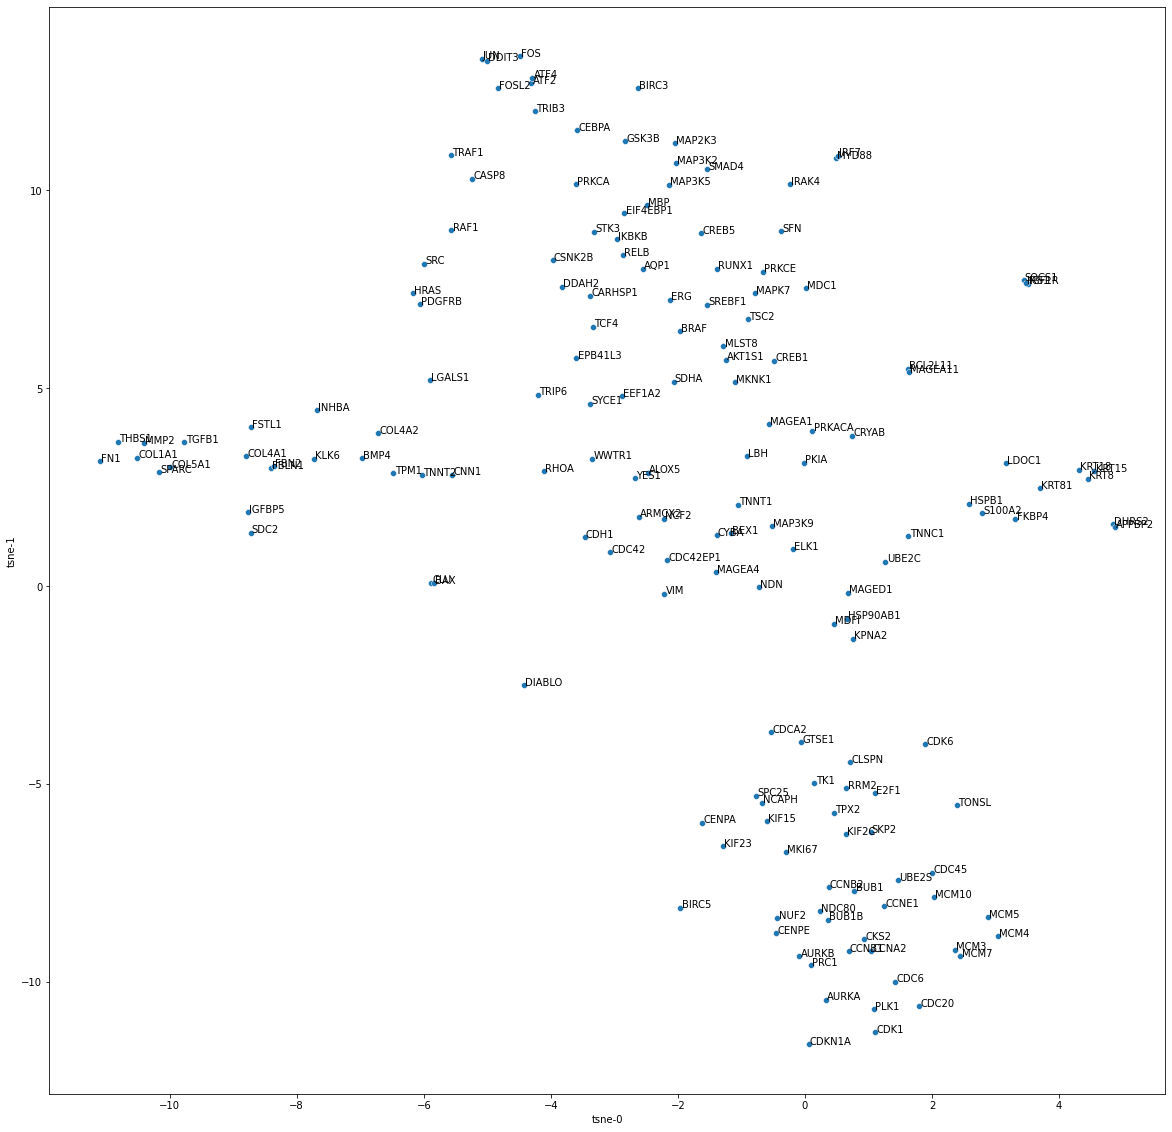

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

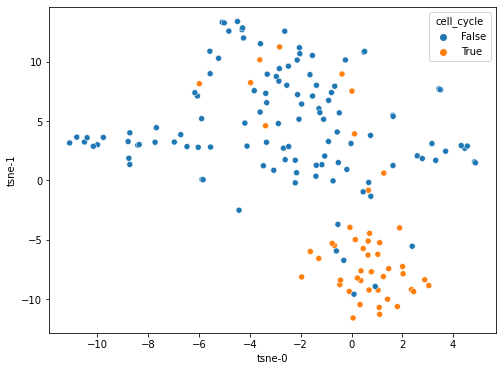

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

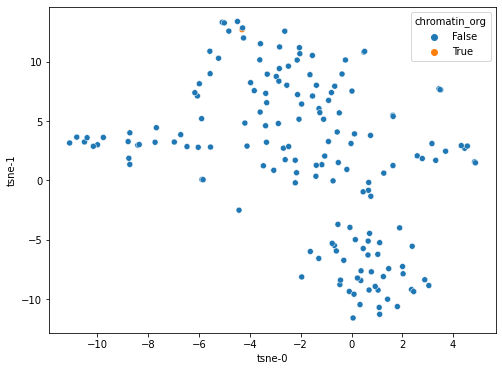

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

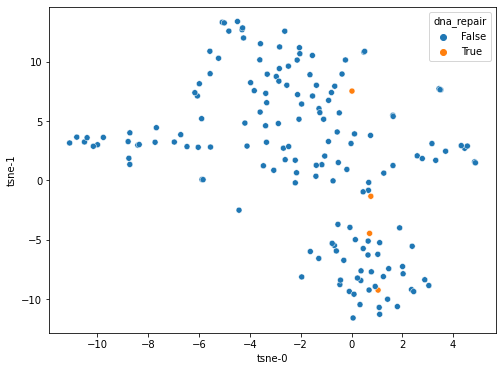

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

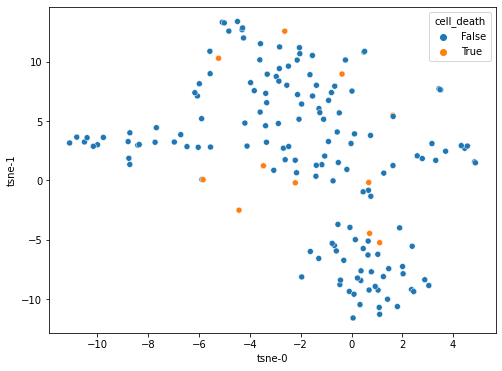

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

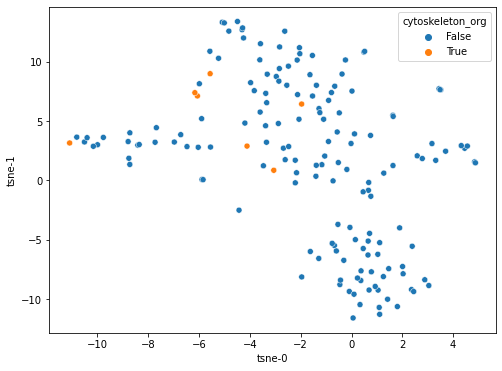

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

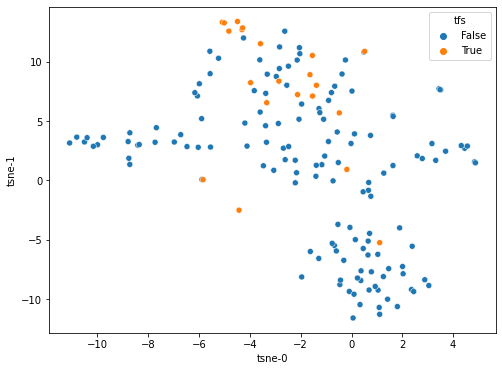

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

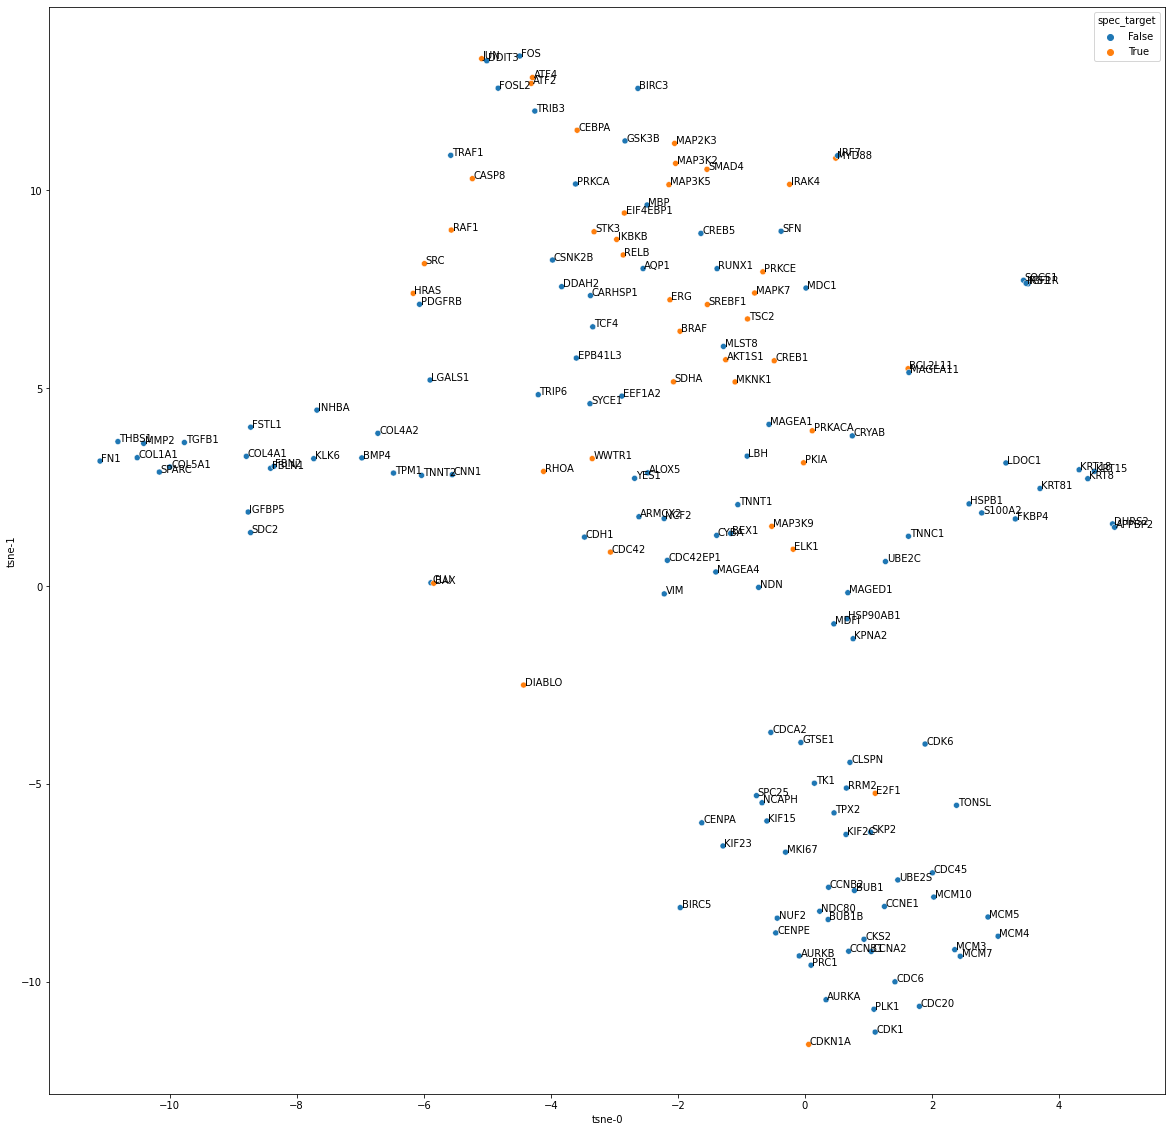

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [40]:
os.makedirs(
    "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi",
    exist_ok=True,
)
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_hallmark.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input plus the 50 hallmark gene set.

In [41]:
node_feature_key = "sc_gex"
gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1126, 128)
      (1): ReLU()
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [42]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [43]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 14.092018127441406
VAL loss: 10.609725952148438
VAL AUC: 0.6630859375 	 AP: 0.6657648912501682
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 9.519444465637207
VAL loss: 7.729534149169922
VAL AUC: 0.66650390625 	 AP: 0.6697270285809497
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 7.137941360473633
VAL loss: 5.505603313446045
VAL AUC: 0.673828125 	 AP: 0.6751501194654881
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 5.449894905090332
VAL loss: 4.225028038024902
VAL AUC: 0.6728515625 	 AP: 0.6744686803012184
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 3.9886584281921387
VAL loss: 3.1500046253204346
VAL AUC: 0.6728515625 	 AP: 0.674375584183176
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 3.136

TRAIN loss: 1.2772133350372314
VAL loss: 1.3182289600372314
VAL AUC: 0.705078125 	 AP: 0.715343008354428
------------------------------------------------------------
EPOCH 54/1000
TRAIN loss: 1.2702208757400513
VAL loss: 1.3329724073410034
VAL AUC: 0.697265625 	 AP: 0.7086125308691646
------------------------------------------------------------
EPOCH 55/1000
TRAIN loss: 1.264716625213623
VAL loss: 1.305214285850525
VAL AUC: 0.6904296875 	 AP: 0.7030879441332867
------------------------------------------------------------
EPOCH 56/1000
TRAIN loss: 1.277532696723938
VAL loss: 1.3232351541519165
VAL AUC: 0.6884765625 	 AP: 0.7020953983193123
------------------------------------------------------------
EPOCH 57/1000
TRAIN loss: 1.2790676355361938
VAL loss: 1.3307722806930542
VAL AUC: 0.68359375 	 AP: 0.6954884144674213
------------------------------------------------------------
EPOCH 58/1000
TRAIN loss: 1.27323579788208
VAL loss: 1.326357126235962
VAL AUC: 0.68359375 	 AP: 0.6956028441838

TRAIN loss: 1.2122845649719238
VAL loss: 1.275115966796875
VAL AUC: 0.6845703125 	 AP: 0.6954028024018186
------------------------------------------------------------
EPOCH 103/1000
TRAIN loss: 1.2004097700119019
VAL loss: 1.2992534637451172
VAL AUC: 0.6796875 	 AP: 0.6864650681286605
------------------------------------------------------------
EPOCH 104/1000
TRAIN loss: 1.1942877769470215
VAL loss: 1.2951319217681885
VAL AUC: 0.671875 	 AP: 0.6814084798623745
------------------------------------------------------------
EPOCH 105/1000
TRAIN loss: 1.2051339149475098
VAL loss: 1.3123548030853271
VAL AUC: 0.6708984375 	 AP: 0.6814221663869295
------------------------------------------------------------
EPOCH 106/1000
TRAIN loss: 1.2136869430541992
VAL loss: 1.2522802352905273
VAL AUC: 0.671875 	 AP: 0.6817509943985406
------------------------------------------------------------
EPOCH 107/1000
TRAIN loss: 1.2067251205444336
VAL loss: 1.311389684677124
VAL AUC: 0.66796875 	 AP: 0.6796310472

VAL AUC: 0.6689453125 	 AP: 0.6791350135233031
------------------------------------------------------------
EPOCH 152/1000
TRAIN loss: 1.1543461084365845
VAL loss: 1.2871081829071045
VAL AUC: 0.6591796875 	 AP: 0.6742275391936744
------------------------------------------------------------
EPOCH 153/1000
TRAIN loss: 1.1724551916122437
VAL loss: 1.2563207149505615
VAL AUC: 0.662109375 	 AP: 0.6753047961479067
------------------------------------------------------------
EPOCH 154/1000
TRAIN loss: 1.1440805196762085
VAL loss: 1.2581124305725098
VAL AUC: 0.666015625 	 AP: 0.6763940523880397
------------------------------------------------------------
EPOCH 155/1000
TRAIN loss: 1.1599538326263428
VAL loss: 1.2207268476486206
VAL AUC: 0.6708984375 	 AP: 0.6839747718836942
------------------------------------------------------------
EPOCH 156/1000
TRAIN loss: 1.1766767501831055
VAL loss: 1.28322434425354
VAL AUC: 0.67578125 	 AP: 0.6885679320184974
--------------------------------------------

TRAIN loss: 1.1108152866363525
VAL loss: 1.288830280303955
VAL AUC: 0.662109375 	 AP: 0.6831642258151102
------------------------------------------------------------
EPOCH 208/1000
TRAIN loss: 1.1182622909545898
VAL loss: 1.2322041988372803
VAL AUC: 0.6591796875 	 AP: 0.6803683788528816
------------------------------------------------------------
EPOCH 209/1000
TRAIN loss: 1.1234983205795288
VAL loss: 1.2450003623962402
VAL AUC: 0.6494140625 	 AP: 0.6716963438583226
------------------------------------------------------------
EPOCH 210/1000
TRAIN loss: 1.1072752475738525
VAL loss: 1.2548184394836426
VAL AUC: 0.634765625 	 AP: 0.6647426505777482
------------------------------------------------------------
EPOCH 211/1000
TRAIN loss: 1.1246962547302246
VAL loss: 1.2431206703186035
VAL AUC: 0.630859375 	 AP: 0.6615769184494329
------------------------------------------------------------
EPOCH 212/1000
TRAIN loss: 1.1431547403335571
VAL loss: 1.2334911823272705
VAL AUC: 0.630859375 	 AP: 0.

TRAIN loss: 1.0769985914230347
VAL loss: 1.1949832439422607
VAL AUC: 0.6357421875 	 AP: 0.67522809180374
------------------------------------------------------------
EPOCH 266/1000
TRAIN loss: 1.0598266124725342
VAL loss: 1.2698166370391846
VAL AUC: 0.6357421875 	 AP: 0.6758452770091788
------------------------------------------------------------
EPOCH 267/1000
TRAIN loss: 1.078439712524414
VAL loss: 1.2738628387451172
VAL AUC: 0.6376953125 	 AP: 0.6773900723690242
------------------------------------------------------------
EPOCH 268/1000
TRAIN loss: 1.120201587677002
VAL loss: 1.2441167831420898
VAL AUC: 0.65625 	 AP: 0.6973343753291329
------------------------------------------------------------
EPOCH 269/1000
TRAIN loss: 1.0856467485427856
VAL loss: 1.245592474937439
VAL AUC: 0.6650390625 	 AP: 0.6996457082183689
------------------------------------------------------------
EPOCH 270/1000
TRAIN loss: 1.0822560787200928
VAL loss: 1.231784462928772
VAL AUC: 0.662109375 	 AP: 0.6974929

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [44]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [45]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [46]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

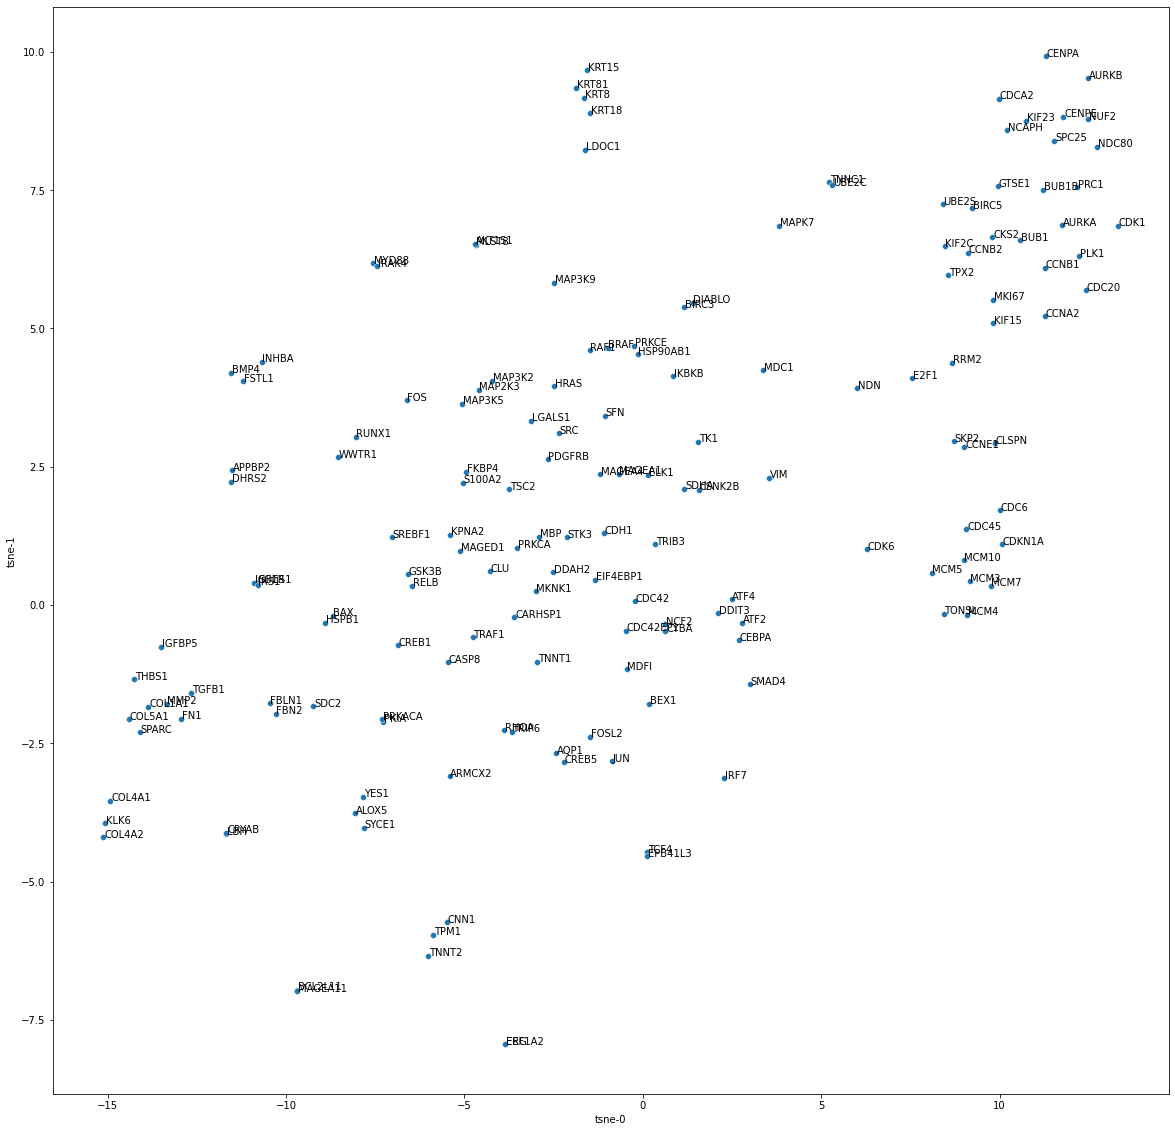

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

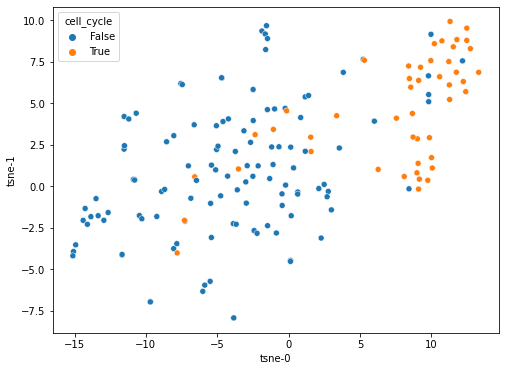

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

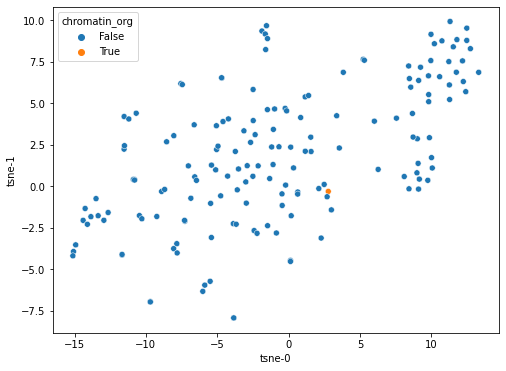

<IPython.core.display.Javascript object>

In [49]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

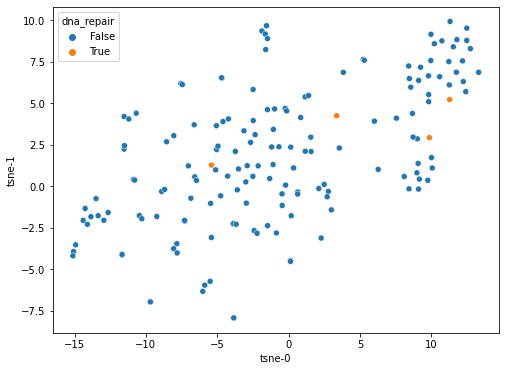

<IPython.core.display.Javascript object>

In [50]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

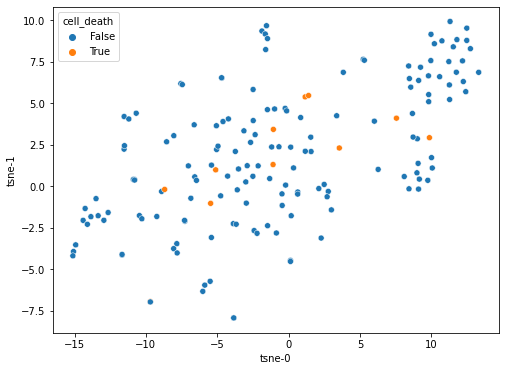

<IPython.core.display.Javascript object>

In [51]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

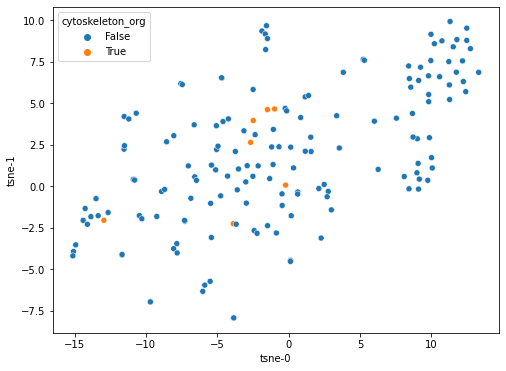

<IPython.core.display.Javascript object>

In [52]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

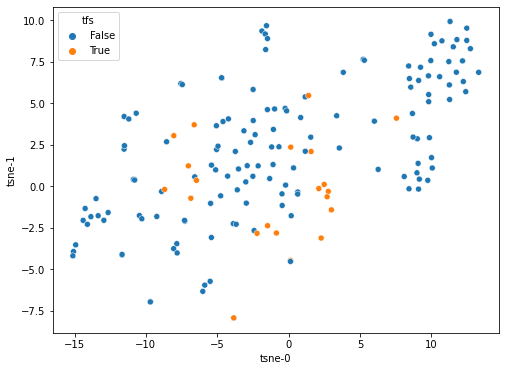

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

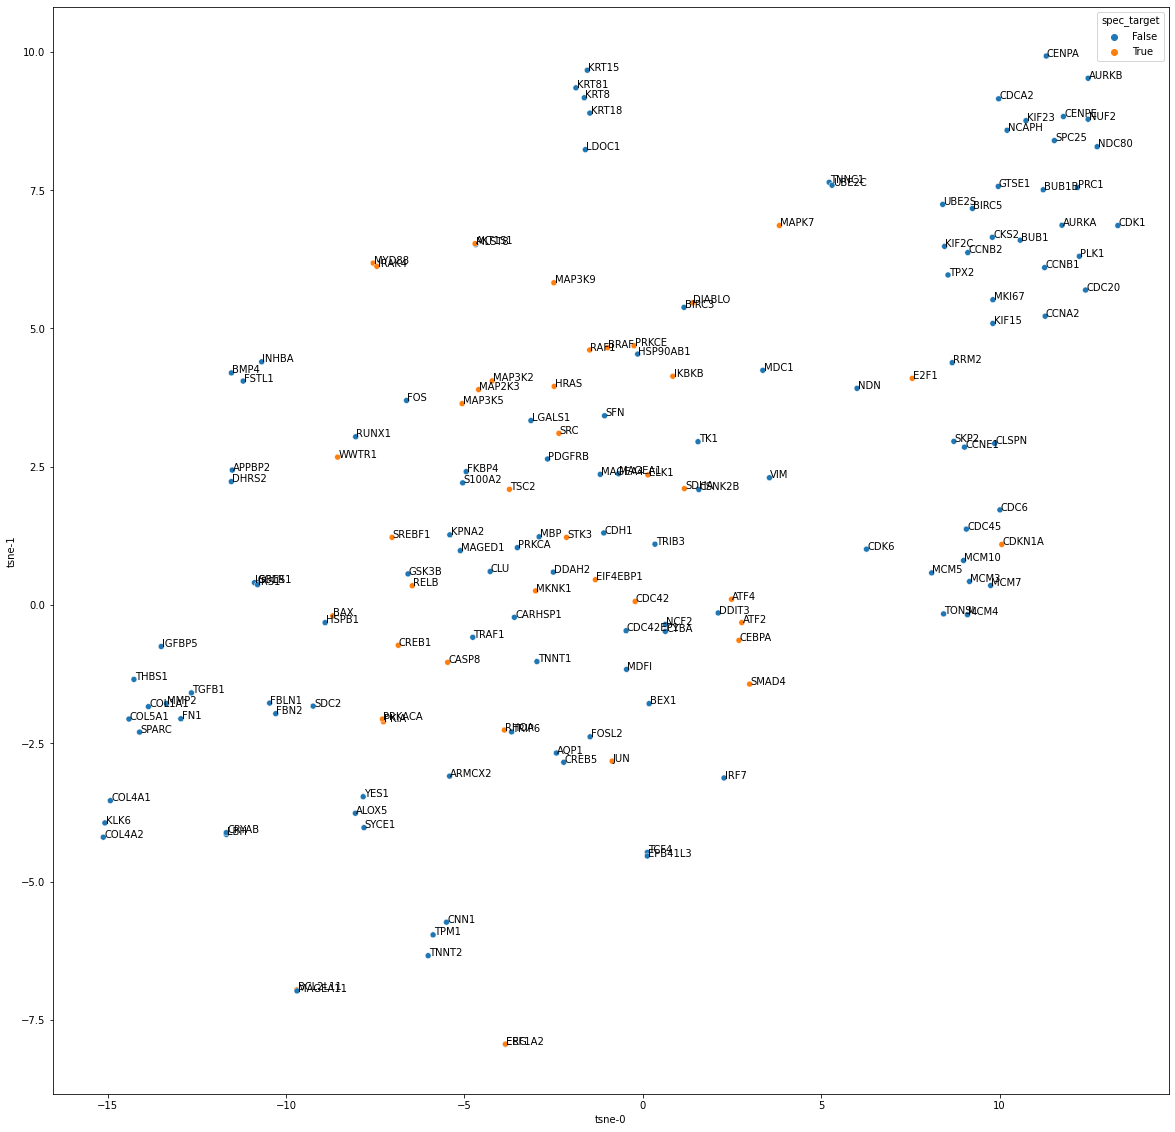

<IPython.core.display.Javascript object>

In [54]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [55]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features w. feature reconstruction

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [137]:
node_feature_key = "sc_gex_hallmark"
# gex_gae = GAE(GCNEncoder(in_channels=1176, hidden_dim=256, out_channels=128))
feat_decoder = torch.nn.Sequential(
    torch.nn.Linear(64, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.PReLU(),
    torch.nn.Linear(256, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 1176),
)
gex_gae = CustomGAE(
    encoder=GCNEncoder(in_channels=1176, hidden_dim=128, out_channels=64),
    adj_decoder=InnerProductDecoder(),
    feat_decoder=feat_decoder,
    alpha=10.0,
)
gex_gae

CustomGAE(
  (gae): GAE(
    (encoder): GCNEncoder(
      (model): Sequential(
        (0): GCNConv(1176, 128)
        (1): ReLU()
        (2): GCNConv(128, 64)
      )
    )
    (decoder): InnerProductDecoder()
  )
  (feat_decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=512, out_features=1176, bias=True)
  )
)

<IPython.core.display.Javascript object>

In [138]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [139]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
    reconstruct_features=True,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 24.407976150512695
VAL loss: 17.33927345275879
VAL AUC: 0.68115234375 	 AP: 0.686909356567725
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 18.894062042236328
VAL loss: 12.927314758300781
VAL AUC: 0.6826171875 	 AP: 0.675670176549144
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 14.904747009277344
VAL loss: 10.79987907409668
VAL AUC: 0.68701171875 	 AP: 0.6857090479898572
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 11.810365676879883
VAL loss: 9.736863136291504
VAL AUC: 0.693359375 	 AP: 0.690630331947699
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 10.296012878417969
VAL loss: 8.034810066223145
VAL AUC: 0.6943359375 	 AP: 0.6910490421413031
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 9.14

VAL loss: 2.3600902557373047
VAL AUC: 0.65234375 	 AP: 0.6891750563607919
------------------------------------------------------------
EPOCH 54/1000
TRAIN loss: 2.3162741661071777
VAL loss: 2.340363025665283
VAL AUC: 0.6513671875 	 AP: 0.68881370113415
------------------------------------------------------------
EPOCH 55/1000
TRAIN loss: 2.2732293605804443
VAL loss: 2.3063488006591797
VAL AUC: 0.65234375 	 AP: 0.6888694653743974
------------------------------------------------------------
EPOCH 56/1000
TRAIN loss: 2.263388156890869
VAL loss: 2.2820286750793457
VAL AUC: 0.6513671875 	 AP: 0.6903691197233164
------------------------------------------------------------
EPOCH 57/1000
TRAIN loss: 2.251906633377075
VAL loss: 2.2404561042785645
VAL AUC: 0.65234375 	 AP: 0.6910474027359628
------------------------------------------------------------
EPOCH 58/1000
TRAIN loss: 2.209181070327759
VAL loss: 2.230128049850464
VAL AUC: 0.6494140625 	 AP: 0.6872522015860758
---------------------------

VAL AUC: 0.642578125 	 AP: 0.6839753343778883
------------------------------------------------------------
EPOCH 106/1000
TRAIN loss: 1.7565102577209473
VAL loss: 1.8416296243667603
VAL AUC: 0.6435546875 	 AP: 0.6844351892774934
------------------------------------------------------------
EPOCH 107/1000
TRAIN loss: 1.7895984649658203
VAL loss: 1.8408606052398682
VAL AUC: 0.6416015625 	 AP: 0.6834017910400987
------------------------------------------------------------
EPOCH 108/1000
TRAIN loss: 1.758678674697876
VAL loss: 1.8764485120773315
VAL AUC: 0.6416015625 	 AP: 0.6827005841105027
------------------------------------------------------------
EPOCH 109/1000
TRAIN loss: 1.7643744945526123
VAL loss: 1.8485839366912842
VAL AUC: 0.642578125 	 AP: 0.6840455435322085
------------------------------------------------------------
EPOCH 110/1000
TRAIN loss: 1.7543847560882568
VAL loss: 1.816187858581543
VAL AUC: 0.642578125 	 AP: 0.6835978996379901
-------------------------------------------

TRAIN loss: 1.6500365734100342
VAL loss: 1.7273082733154297
VAL AUC: 0.615234375 	 AP: 0.6601229889106348
------------------------------------------------------------
EPOCH 153/1000
TRAIN loss: 1.628493309020996
VAL loss: 1.7338905334472656
VAL AUC: 0.6162109375 	 AP: 0.6637711075607384
------------------------------------------------------------
EPOCH 154/1000
TRAIN loss: 1.6405344009399414
VAL loss: 1.724522352218628
VAL AUC: 0.61328125 	 AP: 0.6632031920485013
------------------------------------------------------------
EPOCH 155/1000
TRAIN loss: 1.5904607772827148
VAL loss: 1.7257628440856934
VAL AUC: 0.61328125 	 AP: 0.6632964023954697
------------------------------------------------------------
EPOCH 156/1000
TRAIN loss: 1.613509178161621
VAL loss: 1.7140355110168457
VAL AUC: 0.6142578125 	 AP: 0.6661850753088138
------------------------------------------------------------
EPOCH 157/1000
TRAIN loss: 1.6344975233078003
VAL loss: 1.703667163848877
VAL AUC: 0.6123046875 	 AP: 0.6625

VAL loss: 1.6518696546554565
VAL AUC: 0.599609375 	 AP: 0.6521656964533105
------------------------------------------------------------
EPOCH 199/1000
TRAIN loss: 1.5480546951293945
VAL loss: 1.687106728553772
VAL AUC: 0.5986328125 	 AP: 0.6470200721954826
------------------------------------------------------------
EPOCH 200/1000
TRAIN loss: 1.556696891784668
VAL loss: 1.635709524154663
VAL AUC: 0.59765625 	 AP: 0.6535334431001084
------------------------------------------------------------
EPOCH 201/1000
TRAIN loss: 1.548508644104004
VAL loss: 1.667733907699585
VAL AUC: 0.6025390625 	 AP: 0.65787058953037
------------------------------------------------------------
EPOCH 202/1000
TRAIN loss: 1.5296746492385864
VAL loss: 1.6549569368362427
VAL AUC: 0.60546875 	 AP: 0.6603624327053808
------------------------------------------------------------
EPOCH 203/1000
TRAIN loss: 1.5352354049682617
VAL loss: 1.6681621074676514
VAL AUC: 0.6005859375 	 AP: 0.6557188200475524
---------------------

VAL loss: 1.5374276638031006
VAL AUC: 0.591796875 	 AP: 0.6401906509715054
------------------------------------------------------------
EPOCH 252/1000
TRAIN loss: 1.4479000568389893
VAL loss: 1.5621209144592285
VAL AUC: 0.5986328125 	 AP: 0.6495749286711794
------------------------------------------------------------
EPOCH 253/1000
TRAIN loss: 1.4763157367706299
VAL loss: 1.6079437732696533
VAL AUC: 0.603515625 	 AP: 0.6563130228967132
------------------------------------------------------------
EPOCH 254/1000
TRAIN loss: 1.4975850582122803
VAL loss: 1.6096525192260742
VAL AUC: 0.6044921875 	 AP: 0.6576504086877747
------------------------------------------------------------
EPOCH 255/1000
TRAIN loss: 1.470145344734192
VAL loss: 1.5679279565811157
VAL AUC: 0.607421875 	 AP: 0.660643226628348
------------------------------------------------------------
EPOCH 256/1000
TRAIN loss: 1.4654617309570312
VAL loss: 1.5620830059051514
VAL AUC: 0.6044921875 	 AP: 0.6581516611006804
--------------

VAL loss: 1.5250248908996582
VAL AUC: 0.599609375 	 AP: 0.6538884179179187
------------------------------------------------------------
EPOCH 308/1000
TRAIN loss: 1.4207725524902344
VAL loss: 1.575627326965332
VAL AUC: 0.595703125 	 AP: 0.652859012662637
------------------------------------------------------------
EPOCH 309/1000
TRAIN loss: 1.4138158559799194
VAL loss: 1.5864791870117188
VAL AUC: 0.5947265625 	 AP: 0.6524588602236127
------------------------------------------------------------
EPOCH 310/1000
TRAIN loss: 1.4306317567825317
VAL loss: 1.5770087242126465
VAL AUC: 0.5966796875 	 AP: 0.6537024916906669
------------------------------------------------------------
EPOCH 311/1000
TRAIN loss: 1.4227627515792847
VAL loss: 1.5974814891815186
VAL AUC: 0.599609375 	 AP: 0.6545860495550353
------------------------------------------------------------
EPOCH 312/1000
TRAIN loss: 1.4143931865692139
VAL loss: 1.519648790359497
VAL AUC: 0.6015625 	 AP: 0.6550328436644013
------------------

TRAIN loss: 1.3769735097885132
VAL loss: 1.5196095705032349
VAL AUC: 0.609375 	 AP: 0.6672517547685963
------------------------------------------------------------
EPOCH 359/1000
TRAIN loss: 1.3661938905715942
VAL loss: 1.5514411926269531
VAL AUC: 0.6123046875 	 AP: 0.6667084971211974
------------------------------------------------------------
EPOCH 360/1000
TRAIN loss: 1.3811821937561035
VAL loss: 1.5167500972747803
VAL AUC: 0.619140625 	 AP: 0.6709662577311666
------------------------------------------------------------
EPOCH 361/1000
TRAIN loss: 1.419378638267517
VAL loss: 1.4798061847686768
VAL AUC: 0.619140625 	 AP: 0.6689794446492905
------------------------------------------------------------
EPOCH 362/1000
TRAIN loss: 1.3736493587493896
VAL loss: 1.520524263381958
VAL AUC: 0.6181640625 	 AP: 0.6698428917180947
------------------------------------------------------------
EPOCH 363/1000
TRAIN loss: 1.378157138824463
VAL loss: 1.5442323684692383
VAL AUC: 0.615234375 	 AP: 0.67075

TRAIN loss: 1.3406282663345337
VAL loss: 1.4905369281768799
VAL AUC: 0.6220703125 	 AP: 0.674799156791124
------------------------------------------------------------
EPOCH 412/1000
TRAIN loss: 1.3422163724899292
VAL loss: 1.4790503978729248
VAL AUC: 0.6259765625 	 AP: 0.6799089508594627
------------------------------------------------------------
EPOCH 413/1000
TRAIN loss: 1.3518774509429932
VAL loss: 1.494799256324768
VAL AUC: 0.630859375 	 AP: 0.6895033103307922
------------------------------------------------------------
EPOCH 414/1000
TRAIN loss: 1.3548706769943237
VAL loss: 1.5352504253387451
VAL AUC: 0.6337890625 	 AP: 0.6925320702696779
------------------------------------------------------------
EPOCH 415/1000
TRAIN loss: 1.3132214546203613
VAL loss: 1.4735897779464722
VAL AUC: 0.6318359375 	 AP: 0.6900495969447091
------------------------------------------------------------
EPOCH 416/1000
TRAIN loss: 1.3483192920684814
VAL loss: 1.499030351638794
VAL AUC: 0.6298828125 	 AP: 0

VAL AUC: 0.6474609375 	 AP: 0.7030844148883012
------------------------------------------------------------
EPOCH 462/1000
TRAIN loss: 1.3250969648361206
VAL loss: 1.5163865089416504
VAL AUC: 0.6494140625 	 AP: 0.7070218851407979
------------------------------------------------------------
EPOCH 463/1000
TRAIN loss: 1.324196219444275
VAL loss: 1.4382126331329346
VAL AUC: 0.646484375 	 AP: 0.7051625649823119
------------------------------------------------------------
EPOCH 464/1000
TRAIN loss: 1.313643455505371
VAL loss: 1.4536526203155518
VAL AUC: 0.6435546875 	 AP: 0.7032263107025369
------------------------------------------------------------
EPOCH 465/1000
TRAIN loss: 1.3002487421035767
VAL loss: 1.4836140871047974
VAL AUC: 0.6396484375 	 AP: 0.6996659136027529
------------------------------------------------------------
EPOCH 466/1000
TRAIN loss: 1.2960407733917236
VAL loss: 1.4871991872787476
VAL AUC: 0.638671875 	 AP: 0.6963537981582845
------------------------------------------

VAL loss: 1.4655464887619019
VAL AUC: 0.658203125 	 AP: 0.7153917209421086
------------------------------------------------------------
EPOCH 516/1000
TRAIN loss: 1.2685482501983643
VAL loss: 1.4568095207214355
VAL AUC: 0.6552734375 	 AP: 0.7130248779273997
------------------------------------------------------------
EPOCH 517/1000
TRAIN loss: 1.2753344774246216
VAL loss: 1.464869737625122
VAL AUC: 0.65625 	 AP: 0.7141932010519211
------------------------------------------------------------
EPOCH 518/1000
TRAIN loss: 1.2911447286605835
VAL loss: 1.4993528127670288
VAL AUC: 0.654296875 	 AP: 0.7123756015145013
------------------------------------------------------------
EPOCH 519/1000
TRAIN loss: 1.286716103553772
VAL loss: 1.4619238376617432
VAL AUC: 0.6513671875 	 AP: 0.710920840317093
------------------------------------------------------------
EPOCH 520/1000
TRAIN loss: 1.2892132997512817
VAL loss: 1.476478099822998
VAL AUC: 0.658203125 	 AP: 0.7163917929755457
---------------------

TRAIN loss: 1.2777600288391113
VAL loss: 1.4227670431137085
VAL AUC: 0.677734375 	 AP: 0.7416814922776893
------------------------------------------------------------
EPOCH 566/1000
TRAIN loss: 1.270220160484314
VAL loss: 1.459463119506836
VAL AUC: 0.6796875 	 AP: 0.7353809133963534
------------------------------------------------------------
EPOCH 567/1000
TRAIN loss: 1.2270108461380005
VAL loss: 1.4362348318099976
VAL AUC: 0.6748046875 	 AP: 0.7303376506615943
------------------------------------------------------------
EPOCH 568/1000
TRAIN loss: 1.2965524196624756
VAL loss: 1.4201173782348633
VAL AUC: 0.6767578125 	 AP: 0.7330580129812695
------------------------------------------------------------
EPOCH 569/1000
TRAIN loss: 1.251786708831787
VAL loss: 1.4238715171813965
VAL AUC: 0.6748046875 	 AP: 0.728745912141832
------------------------------------------------------------
EPOCH 570/1000
TRAIN loss: 1.2694858312606812
VAL loss: 1.451225757598877
VAL AUC: 0.6708984375 	 AP: 0.7294

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [140]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [141]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [142]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

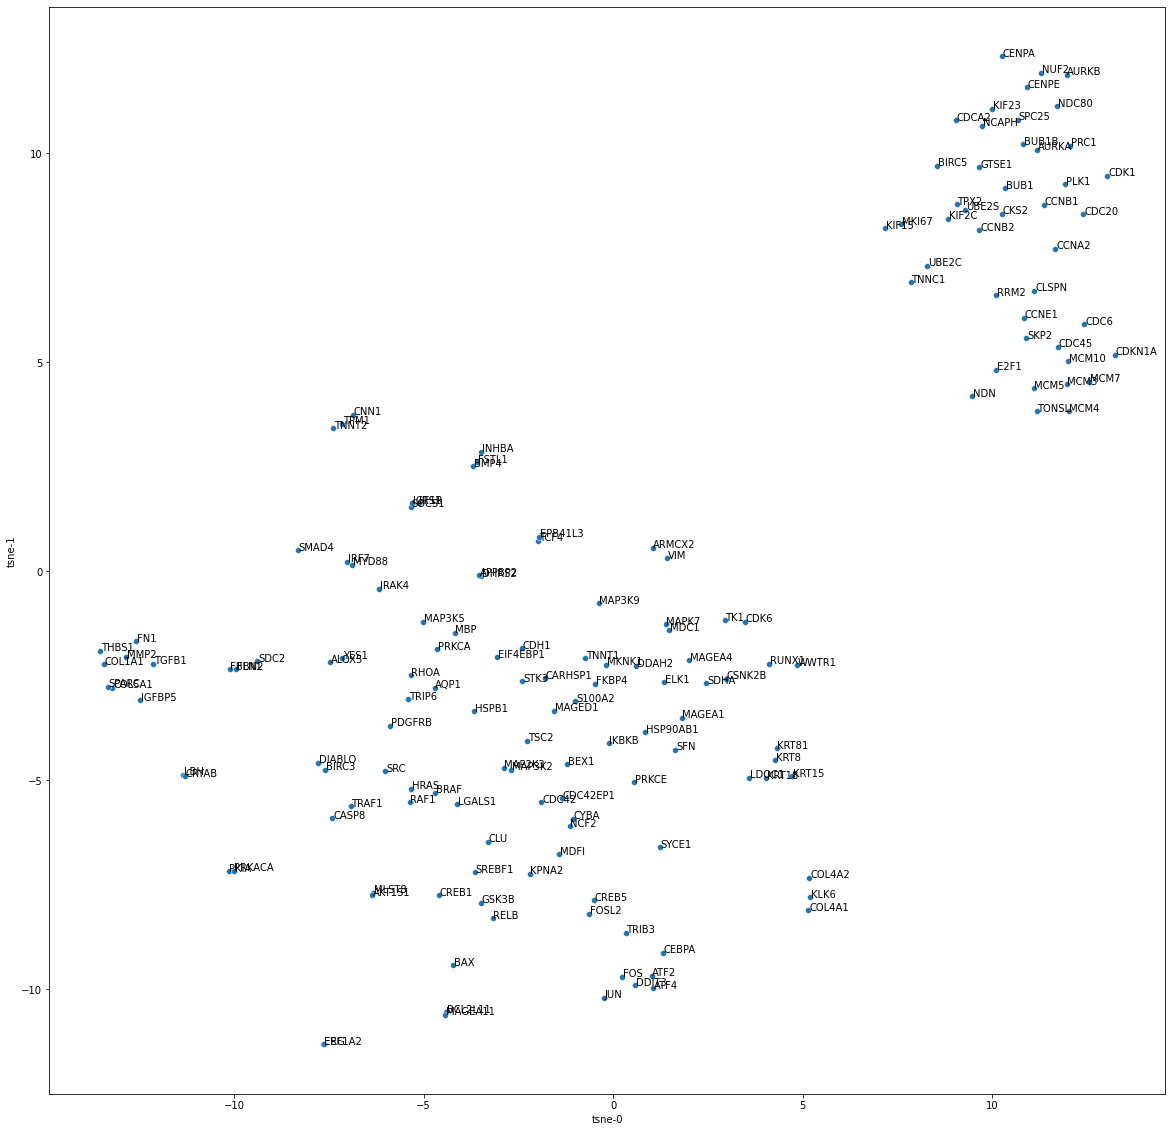

<IPython.core.display.Javascript object>

In [143]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

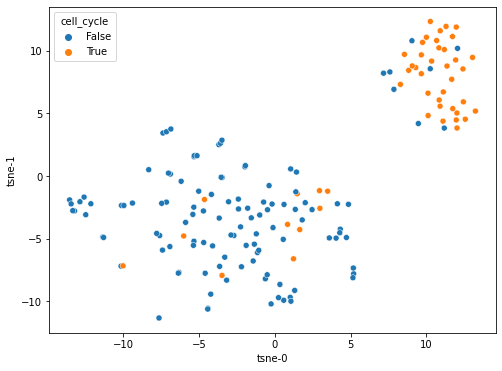

<IPython.core.display.Javascript object>

In [144]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

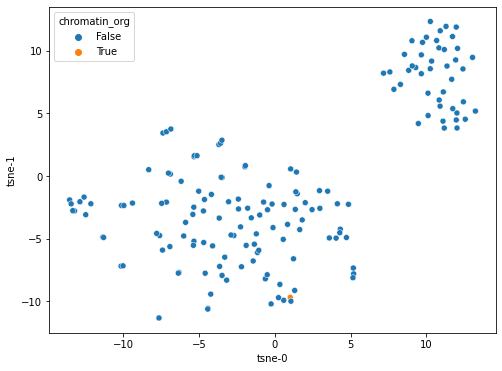

<IPython.core.display.Javascript object>

In [145]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

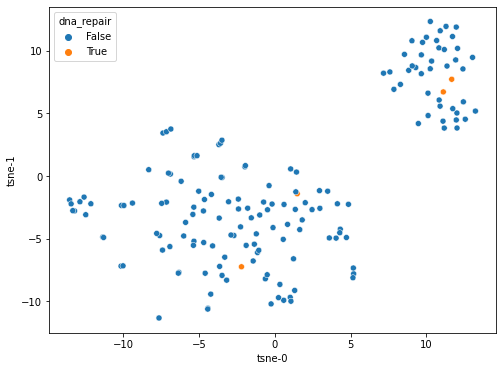

<IPython.core.display.Javascript object>

In [146]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

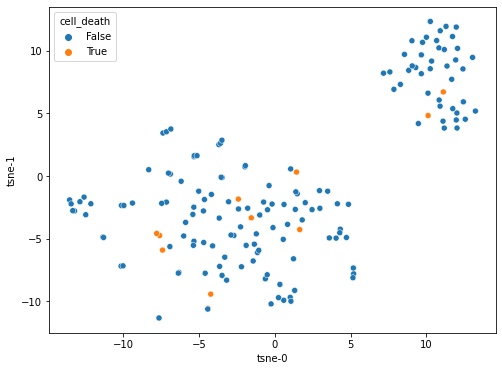

<IPython.core.display.Javascript object>

In [147]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

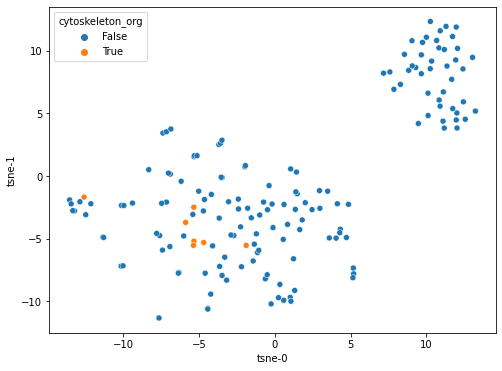

<IPython.core.display.Javascript object>

In [148]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

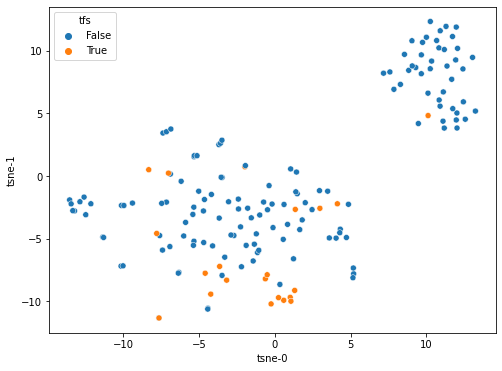

<IPython.core.display.Javascript object>

In [149]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

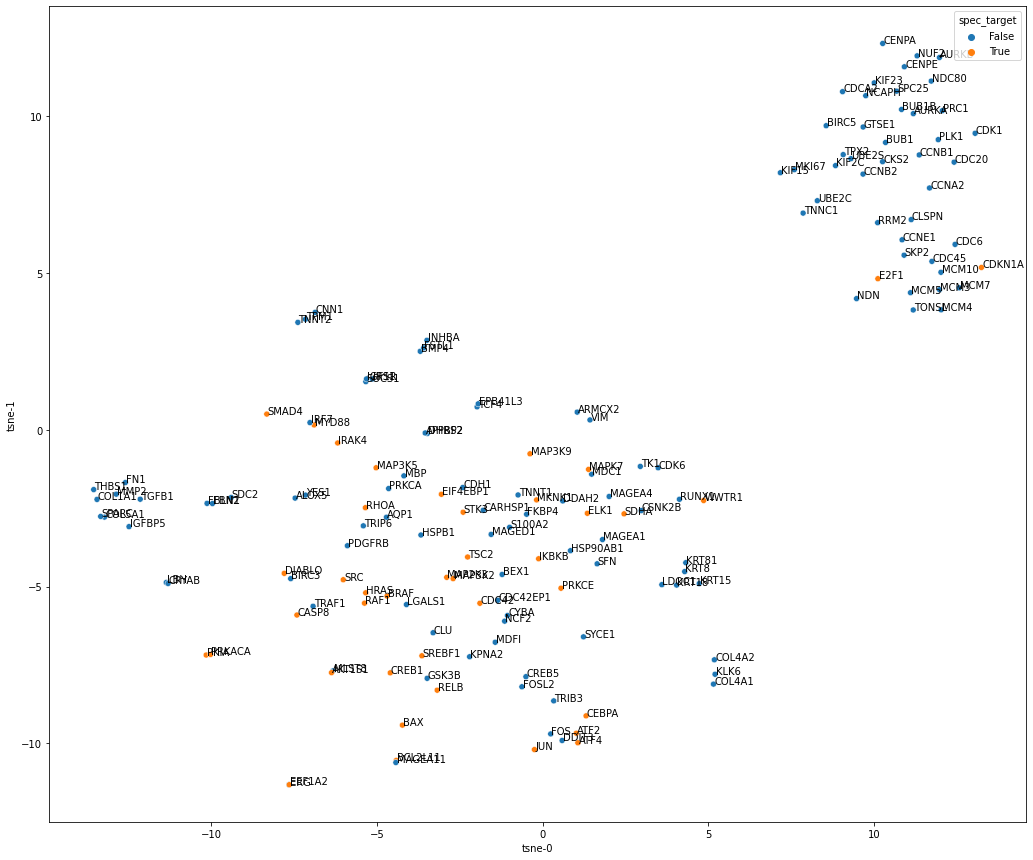

<IPython.core.display.Javascript object>

In [155]:
fig, ax = plt.subplots(figsize=[17.5, 15])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [151]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex_w_feat_recons.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. pseudo-bulk GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [74]:
node_feature_key = "pbulk_gex_hallmark"
gex_gae = GAE(GCNEncoder(in_channels=53, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(53, 128)
      (1): ReLU()
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [75]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [76]:
gex_gae, loss_hist, best_epoch = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 1.33940851688385
VAL loss: 1.3642016649246216
VAL AUC: 0.7666015625 	 AP: 0.7701771813489896
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 1.3248828649520874
VAL loss: 1.3697524070739746
VAL AUC: 0.7646484375 	 AP: 0.7691554351061662
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 1.3177257776260376
VAL loss: 1.3634552955627441
VAL AUC: 0.7607421875 	 AP: 0.7670441783074093
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 1.3272004127502441
VAL loss: 1.3785834312438965
VAL AUC: 0.7578125 	 AP: 0.7637048063267331
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 1.3255271911621094
VAL loss: 1.3652613162994385
VAL AUC: 0.7578125 	 AP: 0.7637048063267331
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 1.3246

VAL loss: 1.3267345428466797
VAL AUC: 0.7294921875 	 AP: 0.7552118235535473
------------------------------------------------------------
EPOCH 54/1000
TRAIN loss: 1.2539629936218262
VAL loss: 1.3188087940216064
VAL AUC: 0.7265625 	 AP: 0.7535950300765961
------------------------------------------------------------
EPOCH 55/1000
TRAIN loss: 1.25870680809021
VAL loss: 1.3081008195877075
VAL AUC: 0.7275390625 	 AP: 0.7547855062670723
------------------------------------------------------------
EPOCH 56/1000
TRAIN loss: 1.2718806266784668
VAL loss: 1.3259295225143433
VAL AUC: 0.724609375 	 AP: 0.7543361581385214
------------------------------------------------------------
EPOCH 57/1000
TRAIN loss: 1.2567509412765503
VAL loss: 1.3105976581573486
VAL AUC: 0.7236328125 	 AP: 0.7540419211255344
------------------------------------------------------------
EPOCH 58/1000
TRAIN loss: 1.269115686416626
VAL loss: 1.3112142086029053
VAL AUC: 0.720703125 	 AP: 0.7524504246851138
----------------------

TRAIN loss: 1.2002652883529663
VAL loss: 1.2641124725341797
VAL AUC: 0.6904296875 	 AP: 0.7367405058732344
------------------------------------------------------------
EPOCH 110/1000
TRAIN loss: 1.1977736949920654
VAL loss: 1.2718336582183838
VAL AUC: 0.689453125 	 AP: 0.7359708014397368
------------------------------------------------------------
EPOCH 111/1000
TRAIN loss: 1.1890982389450073
VAL loss: 1.2869447469711304
VAL AUC: 0.689453125 	 AP: 0.7359708014397368
------------------------------------------------------------
EPOCH 112/1000
TRAIN loss: 1.190433382987976
VAL loss: 1.2944085597991943
VAL AUC: 0.689453125 	 AP: 0.7359708014397368
------------------------------------------------------------
EPOCH 113/1000
TRAIN loss: 1.184804916381836
VAL loss: 1.279464840888977
VAL AUC: 0.6884765625 	 AP: 0.7347372488081578
------------------------------------------------------------
EPOCH 114/1000
TRAIN loss: 1.1875295639038086
VAL loss: 1.2492964267730713
VAL AUC: 0.689453125 	 AP: 0.73

VAL AUC: 0.69140625 	 AP: 0.7448010642443115
------------------------------------------------------------
EPOCH 165/1000
TRAIN loss: 1.126928448677063
VAL loss: 1.2397034168243408
VAL AUC: 0.689453125 	 AP: 0.743835308508819
------------------------------------------------------------
EPOCH 166/1000
TRAIN loss: 1.1714807748794556
VAL loss: 1.291957139968872
VAL AUC: 0.689453125 	 AP: 0.743835308508819
------------------------------------------------------------
EPOCH 167/1000
TRAIN loss: 1.131219506263733
VAL loss: 1.276573896408081
VAL AUC: 0.6875 	 AP: 0.742766443044573
------------------------------------------------------------
EPOCH 168/1000
TRAIN loss: 1.1273670196533203
VAL loss: 1.2703567743301392
VAL AUC: 0.6865234375 	 AP: 0.7418810263779063
------------------------------------------------------------
EPOCH 169/1000
TRAIN loss: 1.1129753589630127
VAL loss: 1.250122308731079
VAL AUC: 0.6875 	 AP: 0.742766443044573
------------------------------------------------------------
EP

TRAIN loss: 1.086969256401062
VAL loss: 1.2454094886779785
VAL AUC: 0.703125 	 AP: 0.7571316916826201
------------------------------------------------------------
EPOCH 214/1000
TRAIN loss: 1.0890562534332275
VAL loss: 1.2378957271575928
VAL AUC: 0.7041015625 	 AP: 0.7574156045898882
------------------------------------------------------------
EPOCH 215/1000
TRAIN loss: 1.0742608308792114
VAL loss: 1.2270808219909668
VAL AUC: 0.705078125 	 AP: 0.7580771469285978
------------------------------------------------------------
EPOCH 216/1000
TRAIN loss: 1.096975326538086
VAL loss: 1.2500052452087402
VAL AUC: 0.7060546875 	 AP: 0.7599658831923342
------------------------------------------------------------
EPOCH 217/1000
TRAIN loss: 1.1047959327697754
VAL loss: 1.2103593349456787
VAL AUC: 0.70703125 	 AP: 0.7604422551435537
------------------------------------------------------------
EPOCH 218/1000
TRAIN loss: 1.0950133800506592
VAL loss: 1.2394614219665527
VAL AUC: 0.70703125 	 AP: 0.760442

TRAIN loss: 1.0755565166473389
VAL loss: 1.2876815795898438
VAL AUC: 0.7255859375 	 AP: 0.7733254403354813
------------------------------------------------------------
EPOCH 261/1000
TRAIN loss: 1.0628588199615479
VAL loss: 1.227882742881775
VAL AUC: 0.7265625 	 AP: 0.7738262416175327
------------------------------------------------------------
EPOCH 262/1000
TRAIN loss: 1.0401920080184937
VAL loss: 1.2024242877960205
VAL AUC: 0.728515625 	 AP: 0.7767236159822983
------------------------------------------------------------
EPOCH 263/1000
TRAIN loss: 1.0368682146072388
VAL loss: 1.2311689853668213
VAL AUC: 0.728515625 	 AP: 0.7767236159822983
------------------------------------------------------------
EPOCH 264/1000
TRAIN loss: 1.081839680671692
VAL loss: 1.2173805236816406
VAL AUC: 0.73046875 	 AP: 0.7784502917069359
------------------------------------------------------------
EPOCH 265/1000
TRAIN loss: 1.0413411855697632
VAL loss: 1.199151635169983
VAL AUC: 0.7314453125 	 AP: 0.78051

TRAIN loss: 1.00612211227417
VAL loss: 1.1552739143371582
VAL AUC: 0.7470703125 	 AP: 0.8029458145204258
------------------------------------------------------------
EPOCH 311/1000
TRAIN loss: 1.0995001792907715
VAL loss: 1.1814812421798706
VAL AUC: 0.7490234375 	 AP: 0.8044313660059773
------------------------------------------------------------
EPOCH 312/1000
TRAIN loss: 1.0090621709823608
VAL loss: 1.2020859718322754
VAL AUC: 0.7490234375 	 AP: 0.8044313660059773
------------------------------------------------------------
EPOCH 313/1000
TRAIN loss: 1.0269520282745361
VAL loss: 1.1614164113998413
VAL AUC: 0.7490234375 	 AP: 0.8044313660059773
------------------------------------------------------------
EPOCH 314/1000
TRAIN loss: 1.0378730297088623
VAL loss: 1.1676034927368164
VAL AUC: 0.7490234375 	 AP: 0.8044313660059773
------------------------------------------------------------
EPOCH 315/1000
TRAIN loss: 1.0292085409164429
VAL loss: 1.2262070178985596
VAL AUC: 0.7490234375 	 AP:

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [77]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [78]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [79]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

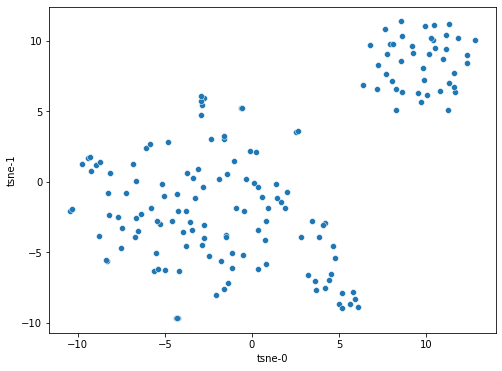

<IPython.core.display.Javascript object>

In [80]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

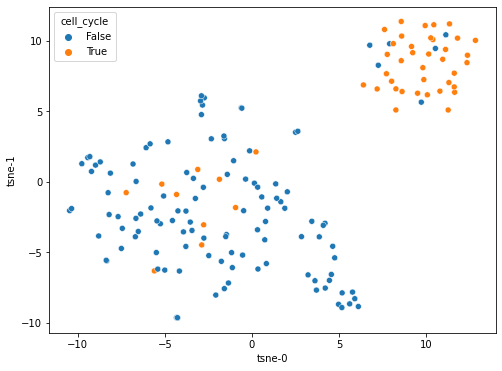

<IPython.core.display.Javascript object>

In [81]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

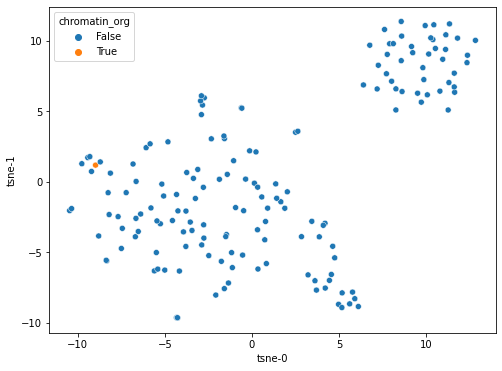

<IPython.core.display.Javascript object>

In [82]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

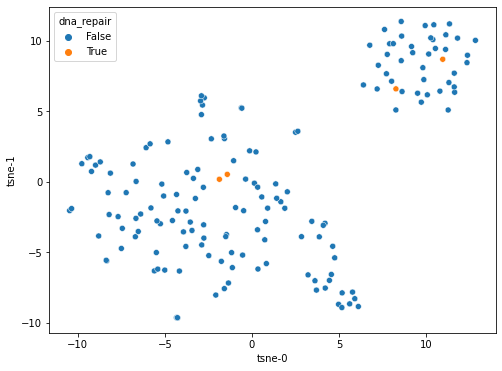

<IPython.core.display.Javascript object>

In [83]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

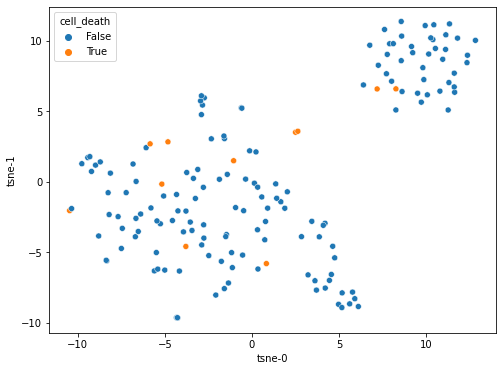

<IPython.core.display.Javascript object>

In [84]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

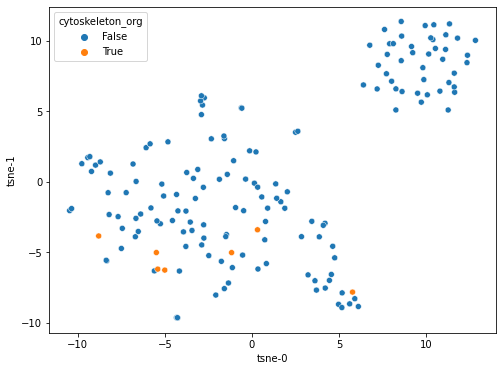

<IPython.core.display.Javascript object>

In [85]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

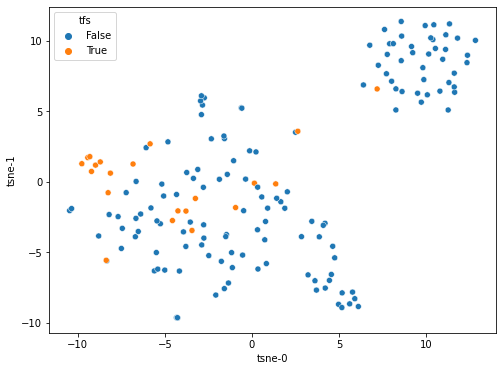

<IPython.core.display.Javascript object>

In [86]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

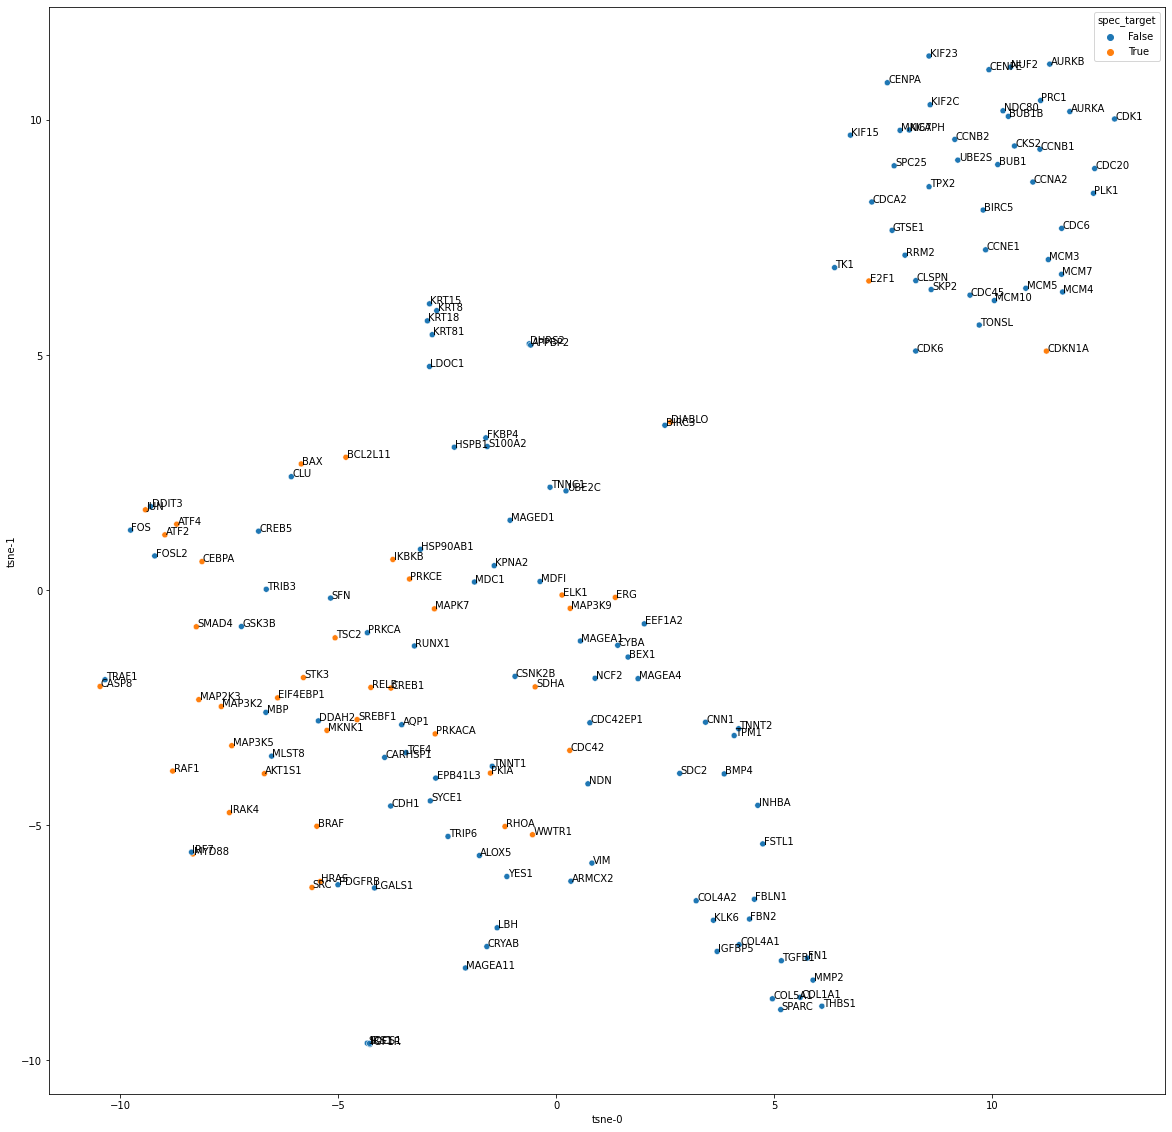

<IPython.core.display.Javascript object>

In [87]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [88]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_pbgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w/o node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [89]:
node_feature_key = "hallmark"
edge_weight_key = "spearmanr"
spearman_gae = GAE(GCNEncoder(in_channels=50, hidden_dim=128, out_channels=64))
spearman_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(50, 128)
      (1): ReLU()
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [90]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [91]:
spearman_gae, loss_hist, best_epoch = train_gae(
    model=spearman_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 2.7184200286865234
VAL loss: 2.050968647003174
VAL AUC: 0.5625 	 AP: 0.6504650304579942
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 2.518127679824829
VAL loss: 2.223541736602783
VAL AUC: 0.5634765625 	 AP: 0.6546316971246608
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 2.4681649208068848
VAL loss: 2.0215020179748535
VAL AUC: 0.5654296875 	 AP: 0.6566212505679894
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 2.8652427196502686
VAL loss: 2.0947279930114746
VAL AUC: 0.5634765625 	 AP: 0.6560460204759526
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 2.7754859924316406
VAL loss: 1.9859124422073364
VAL AUC: 0.5634765625 	 AP: 0.6561941118632837
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 2.59392

TRAIN loss: 2.428006172180176
VAL loss: 1.5770370960235596
VAL AUC: 0.583984375 	 AP: 0.6754547379304059
------------------------------------------------------------
EPOCH 63/1000
TRAIN loss: 2.2866339683532715
VAL loss: 1.5526707172393799
VAL AUC: 0.5859375 	 AP: 0.6770238370223709
------------------------------------------------------------
EPOCH 64/1000
TRAIN loss: 2.392526865005493
VAL loss: 2.0042762756347656
VAL AUC: 0.587890625 	 AP: 0.6779284422855287
------------------------------------------------------------
EPOCH 65/1000
TRAIN loss: 2.3571159839630127
VAL loss: 1.5833899974822998
VAL AUC: 0.5888671875 	 AP: 0.6789947663486575
------------------------------------------------------------
EPOCH 66/1000
TRAIN loss: 2.191105842590332
VAL loss: 1.4907211065292358
VAL AUC: 0.587890625 	 AP: 0.6785308662137048
------------------------------------------------------------
EPOCH 67/1000
TRAIN loss: 2.3618736267089844
VAL loss: 1.5794291496276855
VAL AUC: 0.5869140625 	 AP: 0.678280601

TRAIN loss: 2.1818289756774902
VAL loss: 1.6253541707992554
VAL AUC: 0.625 	 AP: 0.720535917600496
------------------------------------------------------------
EPOCH 119/1000
TRAIN loss: 2.171302080154419
VAL loss: 1.6075689792633057
VAL AUC: 0.626953125 	 AP: 0.7228651101470799
------------------------------------------------------------
EPOCH 120/1000
TRAIN loss: 2.227098226547241
VAL loss: 1.70112144947052
VAL AUC: 0.6279296875 	 AP: 0.7231289088483785
------------------------------------------------------------
EPOCH 121/1000
TRAIN loss: 2.242140769958496
VAL loss: 1.491197109222412
VAL AUC: 0.62890625 	 AP: 0.7234024778719476
------------------------------------------------------------
EPOCH 122/1000
TRAIN loss: 2.2616147994995117
VAL loss: 1.5969434976577759
VAL AUC: 0.6298828125 	 AP: 0.7231800018304393
------------------------------------------------------------
EPOCH 123/1000
TRAIN loss: 2.3919074535369873
VAL loss: 1.4178991317749023
VAL AUC: 0.630859375 	 AP: 0.7246419901345

TRAIN loss: 2.144503116607666
VAL loss: 1.4110935926437378
VAL AUC: 0.6630859375 	 AP: 0.7405541437045611
------------------------------------------------------------
EPOCH 171/1000
TRAIN loss: 2.2426915168762207
VAL loss: 1.3695290088653564
VAL AUC: 0.6640625 	 AP: 0.7408098421265366
------------------------------------------------------------
EPOCH 172/1000
TRAIN loss: 2.1265437602996826
VAL loss: 1.5507503747940063
VAL AUC: 0.6650390625 	 AP: 0.7410658449513954
------------------------------------------------------------
EPOCH 173/1000
TRAIN loss: 2.2521557807922363
VAL loss: 1.5546073913574219
VAL AUC: 0.6650390625 	 AP: 0.7410658449513954
------------------------------------------------------------
EPOCH 174/1000
TRAIN loss: 2.1727793216705322
VAL loss: 1.4022583961486816
VAL AUC: 0.666015625 	 AP: 0.741321992492379
------------------------------------------------------------
EPOCH 175/1000
TRAIN loss: 2.2076053619384766
VAL loss: 1.3551013469696045
VAL AUC: 0.6669921875 	 AP: 0.7

VAL loss: 1.3576785326004028
VAL AUC: 0.6962890625 	 AP: 0.7509706658772691
------------------------------------------------------------
EPOCH 221/1000
TRAIN loss: 2.1202354431152344
VAL loss: 1.327744483947754
VAL AUC: 0.6982421875 	 AP: 0.7516489726950861
------------------------------------------------------------
EPOCH 222/1000
TRAIN loss: 2.114999771118164
VAL loss: 1.341881275177002
VAL AUC: 0.69921875 	 AP: 0.7522790130176669
------------------------------------------------------------
EPOCH 223/1000
TRAIN loss: 2.2351536750793457
VAL loss: 1.5064853429794312
VAL AUC: 0.6982421875 	 AP: 0.7514332152968691
------------------------------------------------------------
EPOCH 224/1000
TRAIN loss: 2.1912388801574707
VAL loss: 1.3155641555786133
VAL AUC: 0.6982421875 	 AP: 0.7514332152968691
------------------------------------------------------------
EPOCH 225/1000
TRAIN loss: 2.280198574066162
VAL loss: 1.3454053401947021
VAL AUC: 0.6982421875 	 AP: 0.7514332152968691
---------------

TRAIN loss: 1.3410906791687012
VAL loss: 1.302584171295166
VAL AUC: 0.76953125 	 AP: 0.8300379578107517
------------------------------------------------------------
EPOCH 277/1000
TRAIN loss: 1.3163172006607056
VAL loss: 1.2998318672180176
VAL AUC: 0.76953125 	 AP: 0.8300379578107517
------------------------------------------------------------
EPOCH 278/1000
TRAIN loss: 1.3055353164672852
VAL loss: 1.3117754459381104
VAL AUC: 0.7705078125 	 AP: 0.83062285085888
------------------------------------------------------------
EPOCH 279/1000
TRAIN loss: 1.3142330646514893
VAL loss: 1.291757345199585
VAL AUC: 0.7705078125 	 AP: 0.83062285085888
------------------------------------------------------------
EPOCH 280/1000
TRAIN loss: 1.308957815170288
VAL loss: 1.298900842666626
VAL AUC: 0.771484375 	 AP: 0.831168485779515
------------------------------------------------------------
EPOCH 281/1000
TRAIN loss: 1.3116588592529297
VAL loss: 1.2951974868774414
VAL AUC: 0.771484375 	 AP: 0.8311684857

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [92]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [93]:
spearman_gae.eval()
latents = spearman_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [94]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

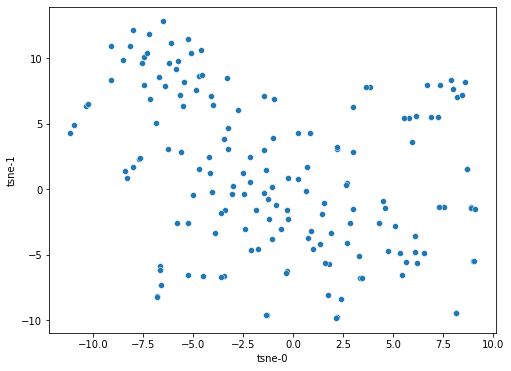

<IPython.core.display.Javascript object>

In [95]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

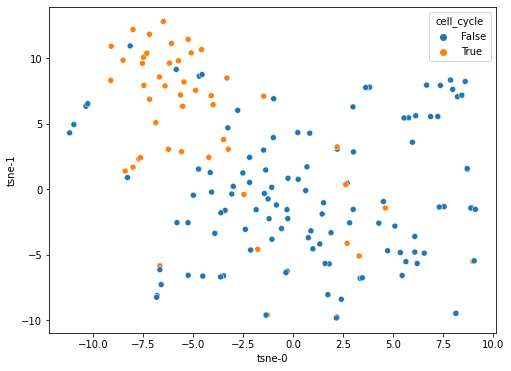

<IPython.core.display.Javascript object>

In [96]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

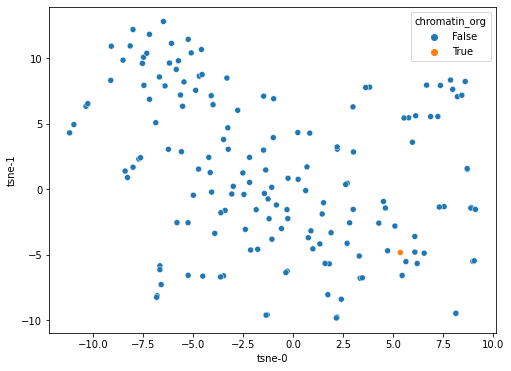

<IPython.core.display.Javascript object>

In [97]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

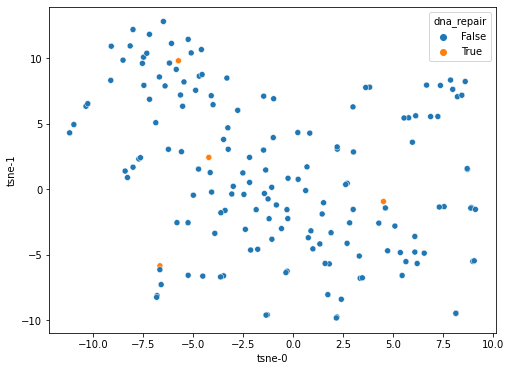

<IPython.core.display.Javascript object>

In [98]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

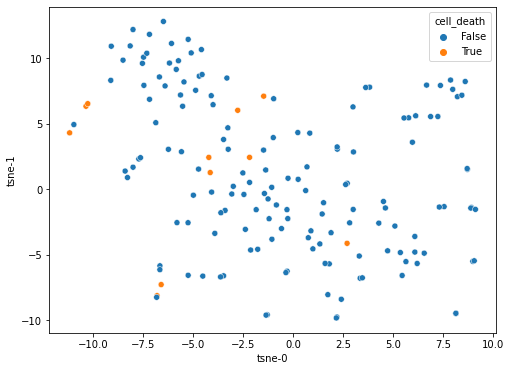

<IPython.core.display.Javascript object>

In [99]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

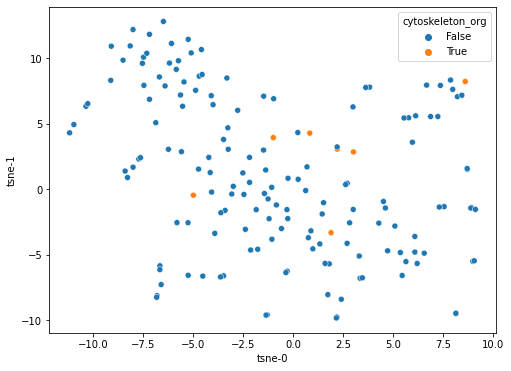

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

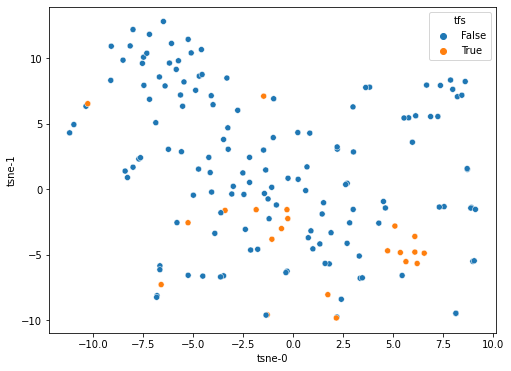

<IPython.core.display.Javascript object>

In [101]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

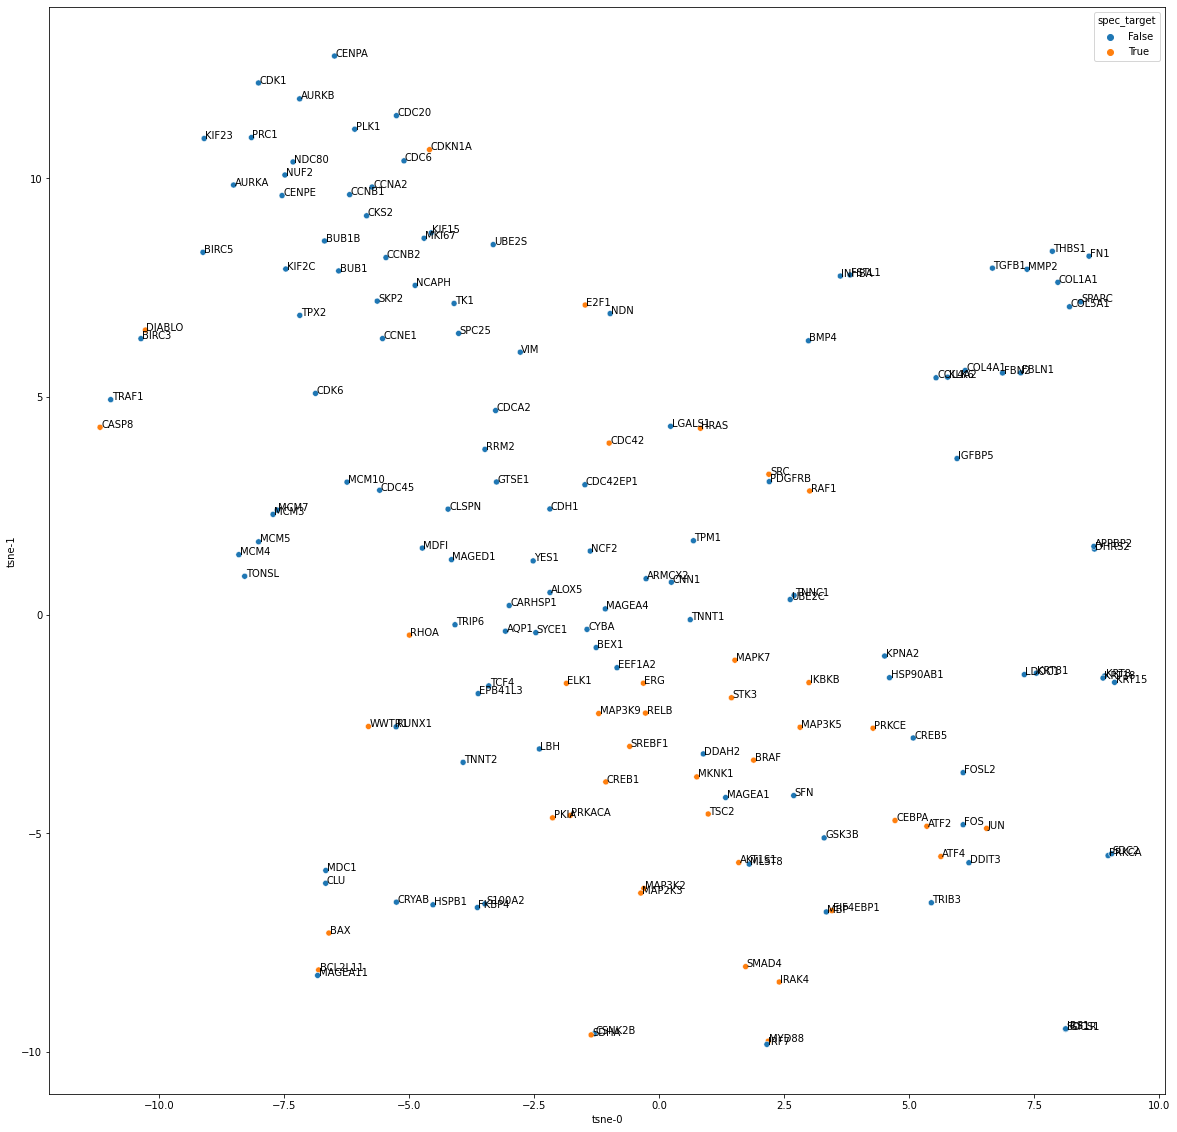

<IPython.core.display.Javascript object>

In [102]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [103]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_wo_gex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE with GEX node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [104]:
node_feature_key = "sc_gex_hallmark"
edge_weight_key = "spearmanr"
spearman_gex_gae = GAE(GCNEncoder(in_channels=1176, hidden_dim=128, out_channels=64))
spearman_gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1176, 128)
      (1): ReLU()
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [105]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [106]:
spearman_gae, loss_hist, best_epoch = train_gae(
    model=spearman_gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=1000,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/1000
TRAIN loss: 24.148466110229492
VAL loss: 20.08470344543457
VAL AUC: 0.5341796875 	 AP: 0.5696259352432275
------------------------------------------------------------
EPOCH 2/1000
TRAIN loss: 18.083120346069336
VAL loss: 15.07529067993164
VAL AUC: 0.53759765625 	 AP: 0.5771336382651875
------------------------------------------------------------
EPOCH 3/1000
TRAIN loss: 13.879806518554688
VAL loss: 11.197690963745117
VAL AUC: 0.54833984375 	 AP: 0.6036648959206816
------------------------------------------------------------
EPOCH 4/1000
TRAIN loss: 10.552839279174805
VAL loss: 8.08881664276123
VAL AUC: 0.54638671875 	 AP: 0.6031294633121552
------------------------------------------------------------
EPOCH 5/1000
TRAIN loss: 8.349347114562988
VAL loss: 6.403893947601318
VAL AUC: 0.54833984375 	 AP: 0.5976124648035837
------------------------------------------------------------
EPOCH 6/1000
TRAIN loss: 

VAL AUC: 0.6123046875 	 AP: 0.7140741835287268
------------------------------------------------------------
EPOCH 51/1000
TRAIN loss: 1.8860305547714233
VAL loss: 1.3866643905639648
VAL AUC: 0.599609375 	 AP: 0.7048760422671516
------------------------------------------------------------
EPOCH 52/1000
TRAIN loss: 1.7949399948120117
VAL loss: 1.3573881387710571
VAL AUC: 0.58984375 	 AP: 0.6939160809696656
------------------------------------------------------------
EPOCH 53/1000
TRAIN loss: 1.7003958225250244
VAL loss: 1.3571820259094238
VAL AUC: 0.591796875 	 AP: 0.6956876837775354
------------------------------------------------------------
EPOCH 54/1000
TRAIN loss: 1.6168582439422607
VAL loss: 1.414090633392334
VAL AUC: 0.6025390625 	 AP: 0.6920525054756831
------------------------------------------------------------
EPOCH 55/1000
TRAIN loss: 1.5160410404205322
VAL loss: 1.3595179319381714
VAL AUC: 0.6005859375 	 AP: 0.6669047646690378
------------------------------------------------

TRAIN loss: 1.3198049068450928
VAL loss: 1.3485366106033325
VAL AUC: 0.560546875 	 AP: 0.6477861289625454
------------------------------------------------------------
EPOCH 110/1000
TRAIN loss: 1.3085956573486328
VAL loss: 1.3421053886413574
VAL AUC: 0.56640625 	 AP: 0.6515389920894056
------------------------------------------------------------
EPOCH 111/1000
TRAIN loss: 1.3057756423950195
VAL loss: 1.3249011039733887
VAL AUC: 0.5703125 	 AP: 0.6539800257766275
------------------------------------------------------------
EPOCH 112/1000
TRAIN loss: 1.3136214017868042
VAL loss: 1.318091630935669
VAL AUC: 0.572265625 	 AP: 0.6536763093599386
------------------------------------------------------------
EPOCH 113/1000
TRAIN loss: 1.3084806203842163
VAL loss: 1.3140435218811035
VAL AUC: 0.568359375 	 AP: 0.6528469590528798
------------------------------------------------------------
EPOCH 114/1000
TRAIN loss: 1.3084654808044434
VAL loss: 1.3184840679168701
VAL AUC: 0.572265625 	 AP: 0.65749

VAL loss: 1.2897536754608154
VAL AUC: 0.6337890625 	 AP: 0.6697421540311039
------------------------------------------------------------
EPOCH 167/1000
TRAIN loss: 1.2771873474121094
VAL loss: 1.3017079830169678
VAL AUC: 0.6376953125 	 AP: 0.6753095740775504
------------------------------------------------------------
EPOCH 168/1000
TRAIN loss: 1.2556146383285522
VAL loss: 1.2954107522964478
VAL AUC: 0.6337890625 	 AP: 0.6787083579237251
------------------------------------------------------------
EPOCH 169/1000
TRAIN loss: 1.26554274559021
VAL loss: 1.2694458961486816
VAL AUC: 0.6328125 	 AP: 0.6776684717606088
------------------------------------------------------------
EPOCH 170/1000
TRAIN loss: 1.2674925327301025
VAL loss: 1.297511339187622
VAL AUC: 0.6328125 	 AP: 0.6752818652931845
------------------------------------------------------------
EPOCH 171/1000
TRAIN loss: 1.2730823755264282
VAL loss: 1.293046474456787
VAL AUC: 0.6328125 	 AP: 0.6725206783783961
----------------------

TRAIN loss: 1.2262709140777588
VAL loss: 1.2720834016799927
VAL AUC: 0.6640625 	 AP: 0.698262433306168
------------------------------------------------------------
EPOCH 219/1000
TRAIN loss: 1.2163233757019043
VAL loss: 1.2644091844558716
VAL AUC: 0.6630859375 	 AP: 0.7016705540375949
------------------------------------------------------------
EPOCH 220/1000
TRAIN loss: 1.2331957817077637
VAL loss: 1.2541704177856445
VAL AUC: 0.669921875 	 AP: 0.714182918346135
------------------------------------------------------------
EPOCH 221/1000
TRAIN loss: 1.2238624095916748
VAL loss: 1.2795445919036865
VAL AUC: 0.666015625 	 AP: 0.7119783196929509
------------------------------------------------------------
EPOCH 222/1000
TRAIN loss: 1.1911176443099976
VAL loss: 1.2600069046020508
VAL AUC: 0.6650390625 	 AP: 0.7131954748507713
------------------------------------------------------------
EPOCH 223/1000
TRAIN loss: 1.2201226949691772
VAL loss: 1.2677228450775146
VAL AUC: 0.666015625 	 AP: 0.714

VAL AUC: 0.6591796875 	 AP: 0.7263986241282356
------------------------------------------------------------
EPOCH 272/1000
TRAIN loss: 1.1815813779830933
VAL loss: 1.2333482503890991
VAL AUC: 0.6787109375 	 AP: 0.7375808515897195
------------------------------------------------------------
EPOCH 273/1000
TRAIN loss: 1.1661421060562134
VAL loss: 1.2428317070007324
VAL AUC: 0.6728515625 	 AP: 0.733497561668792
------------------------------------------------------------
EPOCH 274/1000
TRAIN loss: 1.1712933778762817
VAL loss: 1.230445384979248
VAL AUC: 0.6669921875 	 AP: 0.7242747090362962
------------------------------------------------------------
EPOCH 275/1000
TRAIN loss: 1.164387583732605
VAL loss: 1.229612946510315
VAL AUC: 0.6748046875 	 AP: 0.7301988048021438
------------------------------------------------------------
EPOCH 276/1000
TRAIN loss: 1.1681817770004272
VAL loss: 1.2316080331802368
VAL AUC: 0.6767578125 	 AP: 0.7299600753159841
------------------------------------------

VAL AUC: 0.6884765625 	 AP: 0.7347443945239416
------------------------------------------------------------
EPOCH 328/1000
TRAIN loss: 1.1182341575622559
VAL loss: 1.2792167663574219
VAL AUC: 0.69140625 	 AP: 0.730923361952087
------------------------------------------------------------
EPOCH 329/1000
TRAIN loss: 1.123814582824707
VAL loss: 1.2297626733779907
VAL AUC: 0.677734375 	 AP: 0.7266852337297844
------------------------------------------------------------
EPOCH 330/1000
TRAIN loss: 1.1295835971832275
VAL loss: 1.2347376346588135
VAL AUC: 0.677734375 	 AP: 0.7320659902712876
------------------------------------------------------------
EPOCH 331/1000
TRAIN loss: 1.1510891914367676
VAL loss: 1.214451551437378
VAL AUC: 0.6767578125 	 AP: 0.7316032707391886
------------------------------------------------------------
EPOCH 332/1000
TRAIN loss: 1.1522042751312256
VAL loss: 1.2031497955322266
VAL AUC: 0.6845703125 	 AP: 0.7389048318866802
---------------------------------------------

VAL loss: 1.1759124994277954
VAL AUC: 0.7392578125 	 AP: 0.7911144536677617
------------------------------------------------------------
EPOCH 376/1000
TRAIN loss: 1.0895129442214966
VAL loss: 1.1863470077514648
VAL AUC: 0.7314453125 	 AP: 0.7855664438870775
------------------------------------------------------------
EPOCH 377/1000
TRAIN loss: 1.0815123319625854
VAL loss: 1.1933040618896484
VAL AUC: 0.736328125 	 AP: 0.7947058768125073
------------------------------------------------------------
EPOCH 378/1000
TRAIN loss: 1.0858290195465088
VAL loss: 1.1938549280166626
VAL AUC: 0.72265625 	 AP: 0.7792886344847284
------------------------------------------------------------
EPOCH 379/1000
TRAIN loss: 1.0548274517059326
VAL loss: 1.1994351148605347
VAL AUC: 0.7080078125 	 AP: 0.7636447136848504
------------------------------------------------------------
EPOCH 380/1000
TRAIN loss: 1.08626389503479
VAL loss: 1.2595685720443726
VAL AUC: 0.705078125 	 AP: 0.754596752313845
----------------

VAL AUC: 0.740234375 	 AP: 0.8025156352943499
------------------------------------------------------------
EPOCH 433/1000
TRAIN loss: 1.007590413093567
VAL loss: 1.1555973291397095
VAL AUC: 0.7412109375 	 AP: 0.8070845524539243
------------------------------------------------------------
EPOCH 434/1000
TRAIN loss: 1.0572021007537842
VAL loss: 1.18123197555542
VAL AUC: 0.736328125 	 AP: 0.8002836425696958
------------------------------------------------------------
EPOCH 435/1000
TRAIN loss: 1.0675487518310547
VAL loss: 1.1909728050231934
VAL AUC: 0.7314453125 	 AP: 0.7971854840543329
------------------------------------------------------------
EPOCH 436/1000
TRAIN loss: 1.0664801597595215
VAL loss: 1.197751760482788
VAL AUC: 0.7197265625 	 AP: 0.7861590896096327
------------------------------------------------------------
EPOCH 437/1000
TRAIN loss: 1.0077037811279297
VAL loss: 1.1908193826675415
VAL AUC: 0.7109375 	 AP: 0.7804682963851439
-----------------------------------------------

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [107]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [108]:
spearman_gex_gae.eval()
latents = spearman_gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [109]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

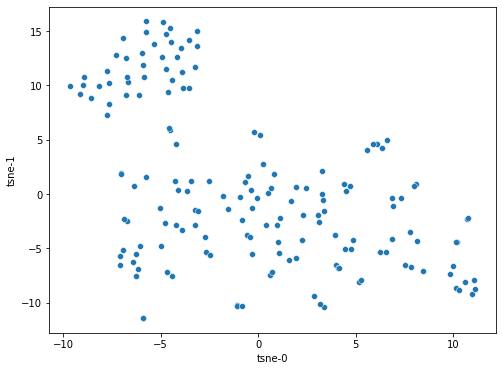

<IPython.core.display.Javascript object>

In [110]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

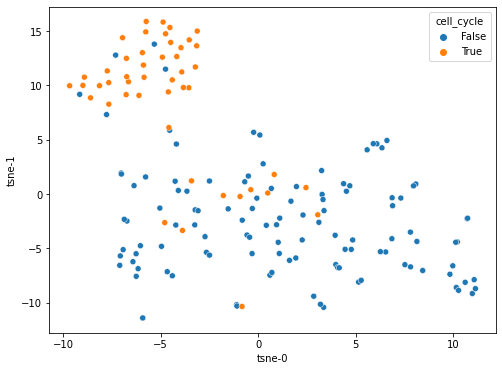

<IPython.core.display.Javascript object>

In [111]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

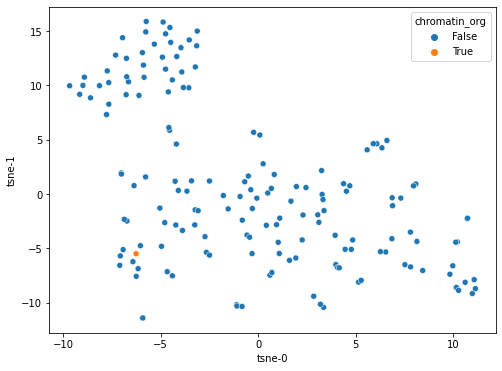

<IPython.core.display.Javascript object>

In [112]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

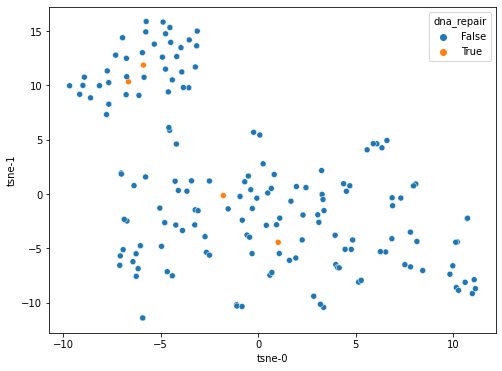

<IPython.core.display.Javascript object>

In [113]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

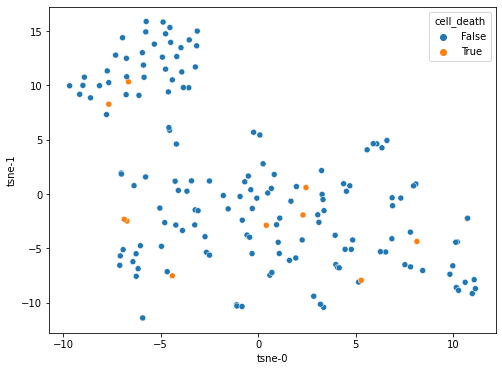

<IPython.core.display.Javascript object>

In [114]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

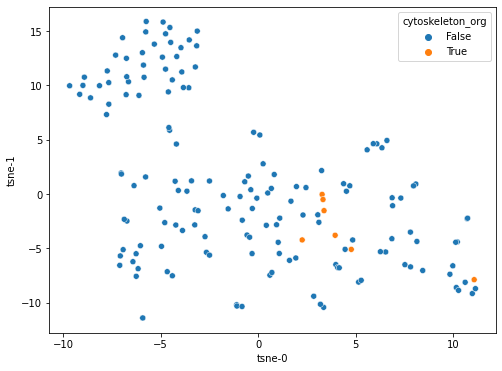

<IPython.core.display.Javascript object>

In [115]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

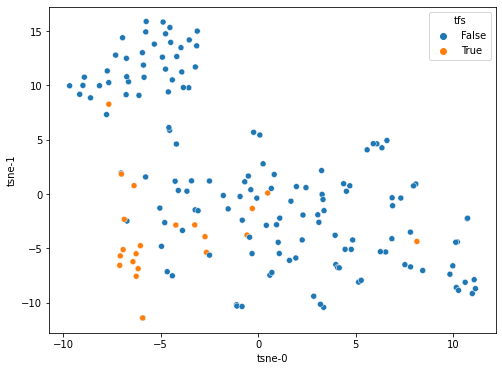

<IPython.core.display.Javascript object>

In [116]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

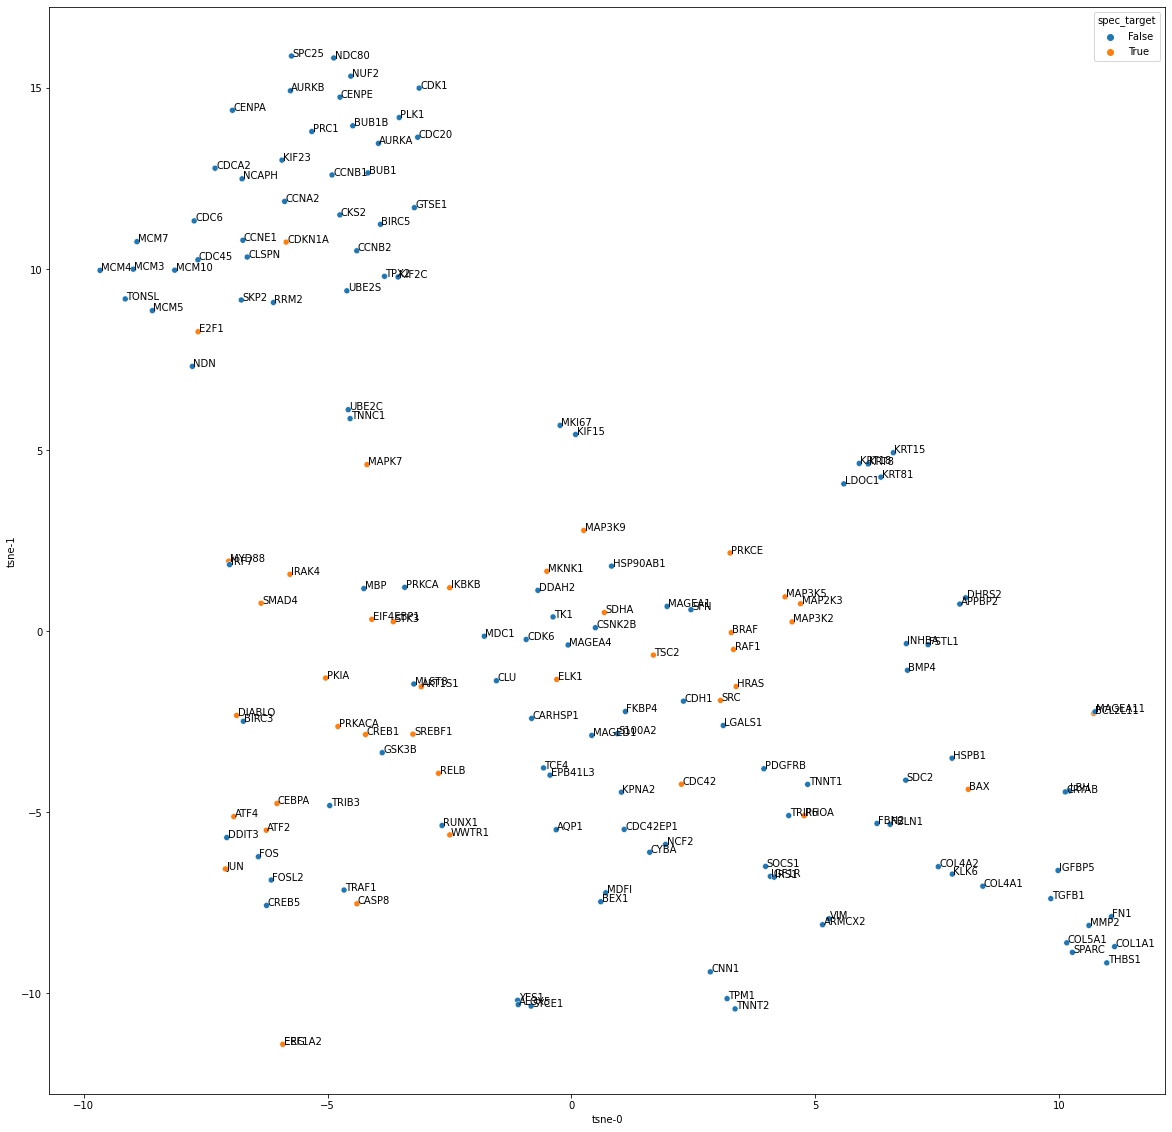

<IPython.core.display.Javascript object>

In [117]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [118]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/gae_conf_hub_ppi_w_scgex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---

## 4. Node2Vec embeddings

An alternative approach for the node embeddings is Node2Vec that learns an embedding that preserves information of the local neighborhood of it. To this end, we run a number of biased random walks and find node embeddings that captures the likelihood of the co-occurence of two nodes in a respective biased random-walk similar to the word2vec model.

To train the model, we sample positive samples that describe a random-walk of pre-defined size on the graph and negative samples which are not based on the graph structure but purely random.

---

### 4.1. DeepWalk w/o edge weights

We will focus for simplicity on the unbiased case of Node2Vec also known as DeepWalk and first will use that each edge in the derived interactome has weight 1.

#### Model definition

We set the length of the random walks to 30 nodes, the context size to 10 nodes and define to run 50 walks per node. For reasons of comparability we set the embedding dimension to 1.

In [119]:
latent_dim = 64
context_size = 10
walks_per_node = 50
walk_length = 30

<IPython.core.display.Javascript object>

In [120]:
n2v_model = Node2Vec(
    graph_data.edge_index,
    embedding_dim=latent_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)
n2v_model.device = device
print(n2v_model)

Node2Vec(163, 64)


<IPython.core.display.Javascript object>

Next, we define the dataloader for a batch size of 128, which corresponds to 128 x 50 x 3 random walks per batch. To speed up the computation we will distribute the computation across 5 different threads. Additionally we define a SparseAdam optimizer to train our model.

In [121]:
batch_size = 128
num_workers = 10

<IPython.core.display.Javascript object>

In [122]:
n2v_loader = n2v_model.loader(
    batch_size=batch_size, shuffle=True, num_workers=num_workers
)
n2v_optimizer = torch.optim.SparseAdam(list(n2v_model.parameters()), lr=0.01)

<IPython.core.display.Javascript object>

#### Model training

We now run the model training once more for 300 epochs, since there is no standardized way to evaluate purely unsupervised token-based embeddings, we will not stop the training early.

In [123]:
def process_single_epoch_n2v(model, optimizer, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(model.device), neg_rw.to(model.device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_n2v_model(model, optimizer, loader, n_epochs=300):
    for i in range(n_epochs):
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        loss = process_single_epoch_n2v(model=model, optimizer=optimizer, loader=loader)
        print("TRAIN loss:", loss)
        print("---" * 30)
    return model

<IPython.core.display.Javascript object>

In [124]:
fitted_n2v_model = train_n2v_model(
    model=n2v_model, optimizer=n2v_optimizer, loader=n2v_loader
)

EPOCH 1/300
TRAIN loss: 6.906039476394653
------------------------------------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 6.544378280639648
------------------------------------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 6.231058835983276
------------------------------------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 5.927300930023193
------------------------------------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 5.648692607879639
------------------------------------------------------------------------------------------
EPOCH 6/300
TRAIN loss: 5.408246755599976
------------------------------------------------------------------------------------------
EPOCH 7/300
TRAIN loss: 5.177081108093262
------------------------------------------------------------------------------------------
EPOCH 8/300
TRAIN loss: 4.946382522583008
---------------------------

TRAIN loss: 1.6351643204689026
------------------------------------------------------------------------------------------
EPOCH 63/300
TRAIN loss: 1.620754063129425
------------------------------------------------------------------------------------------
EPOCH 64/300
TRAIN loss: 1.6124070882797241
------------------------------------------------------------------------------------------
EPOCH 65/300
TRAIN loss: 1.5938615798950195
------------------------------------------------------------------------------------------
EPOCH 66/300
TRAIN loss: 1.578444242477417
------------------------------------------------------------------------------------------
EPOCH 67/300
TRAIN loss: 1.5624698996543884
------------------------------------------------------------------------------------------
EPOCH 68/300
TRAIN loss: 1.545156717300415
------------------------------------------------------------------------------------------
EPOCH 69/300
TRAIN loss: 1.5309082865715027
---------------------------

TRAIN loss: 1.1928890347480774
------------------------------------------------------------------------------------------
EPOCH 124/300
TRAIN loss: 1.1959006786346436
------------------------------------------------------------------------------------------
EPOCH 125/300
TRAIN loss: 1.1913176774978638
------------------------------------------------------------------------------------------
EPOCH 126/300
TRAIN loss: 1.1874533891677856
------------------------------------------------------------------------------------------
EPOCH 127/300
TRAIN loss: 1.1887719631195068
------------------------------------------------------------------------------------------
EPOCH 128/300
TRAIN loss: 1.1820856928825378
------------------------------------------------------------------------------------------
EPOCH 129/300
TRAIN loss: 1.1806321740150452
------------------------------------------------------------------------------------------
EPOCH 130/300
TRAIN loss: 1.1781474351882935
-----------------

TRAIN loss: 1.123542308807373
------------------------------------------------------------------------------------------
EPOCH 185/300
TRAIN loss: 1.124809205532074
------------------------------------------------------------------------------------------
EPOCH 186/300
TRAIN loss: 1.1197529435157776
------------------------------------------------------------------------------------------
EPOCH 187/300
TRAIN loss: 1.1220365762710571
------------------------------------------------------------------------------------------
EPOCH 188/300
TRAIN loss: 1.1184069514274597
------------------------------------------------------------------------------------------
EPOCH 189/300
TRAIN loss: 1.1188406944274902
------------------------------------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 1.1198384761810303
------------------------------------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 1.1217520236968994
-------------------

TRAIN loss: 1.1069941520690918
------------------------------------------------------------------------------------------
EPOCH 246/300
TRAIN loss: 1.1118838787078857
------------------------------------------------------------------------------------------
EPOCH 247/300
TRAIN loss: 1.1090337038040161
------------------------------------------------------------------------------------------
EPOCH 248/300
TRAIN loss: 1.1063719987869263
------------------------------------------------------------------------------------------
EPOCH 249/300
TRAIN loss: 1.103790283203125
------------------------------------------------------------------------------------------
EPOCH 250/300
TRAIN loss: 1.1072073578834534
------------------------------------------------------------------------------------------
EPOCH 251/300
TRAIN loss: 1.106461524963379
------------------------------------------------------------------------------------------
EPOCH 252/300
TRAIN loss: 1.1044682264328003
-------------------

<IPython.core.display.Javascript object>

The loss seems to has converged at 1.105 after training.

#### Visualization of the embeddings

In [125]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [126]:
fitted_n2v_model.eval()
latents = (
    fitted_n2v_model(torch.arange(graph_data.num_nodes, device=device))
    .cpu()
    .detach()
    .numpy()
)

<IPython.core.display.Javascript object>

In [127]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

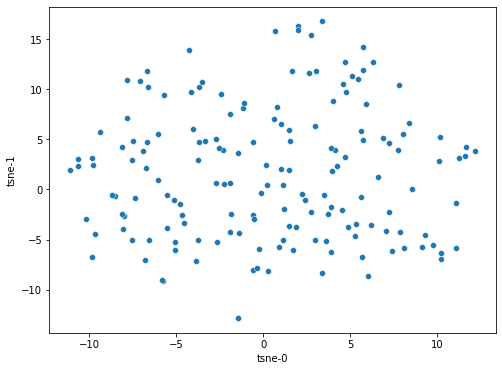

<IPython.core.display.Javascript object>

In [128]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

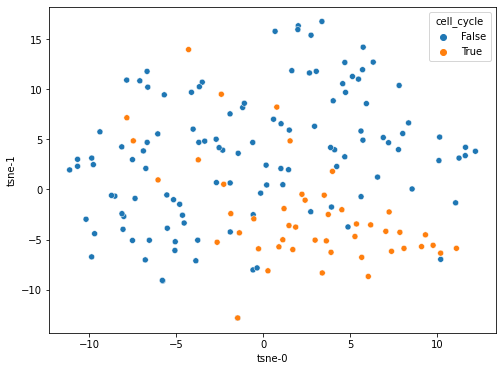

<IPython.core.display.Javascript object>

In [129]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

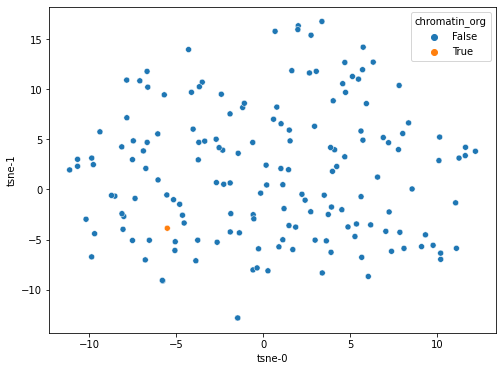

<IPython.core.display.Javascript object>

In [130]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

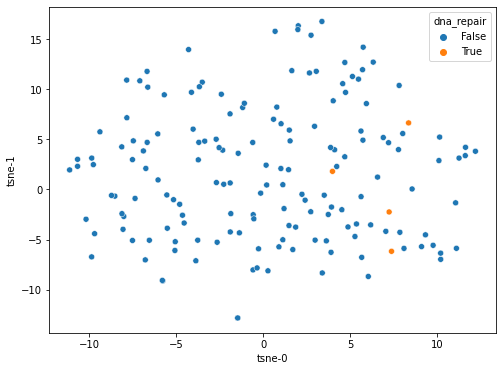

<IPython.core.display.Javascript object>

In [131]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

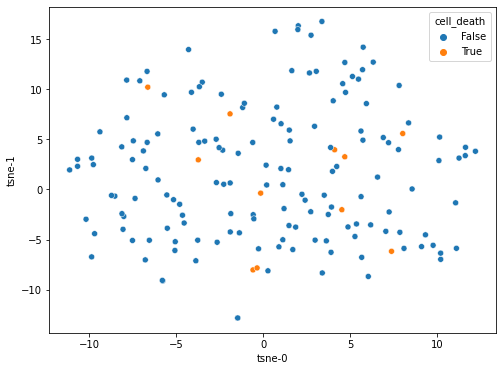

<IPython.core.display.Javascript object>

In [132]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

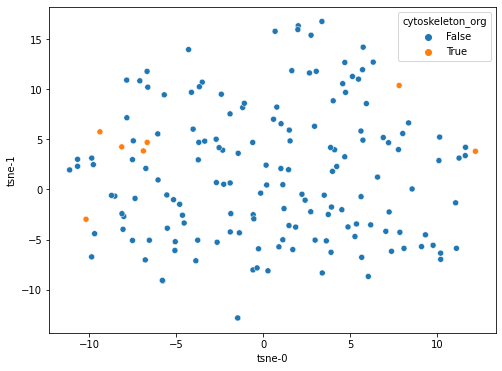

<IPython.core.display.Javascript object>

In [133]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

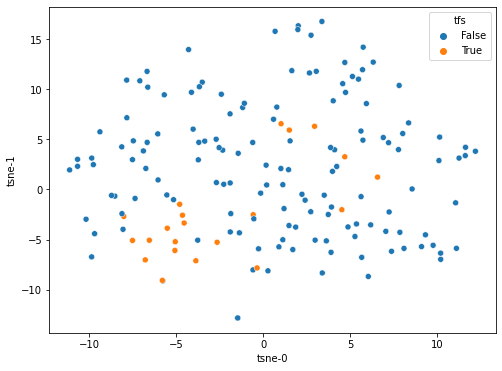

<IPython.core.display.Javascript object>

In [134]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

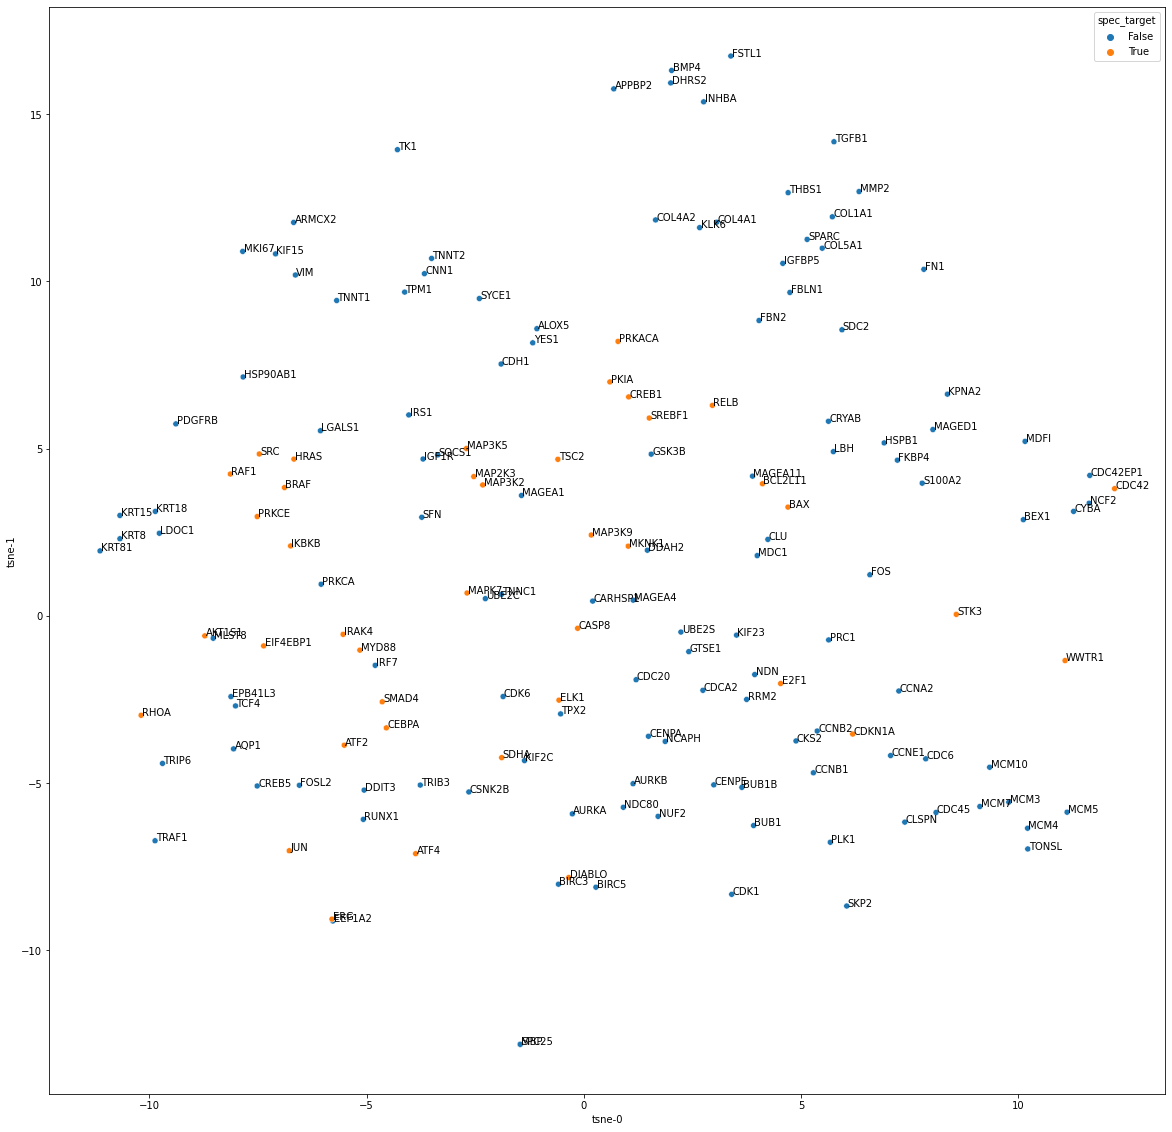

<IPython.core.display.Javascript object>

In [135]:
fig, ax = plt.subplots(figsize=[20, 20])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)

#### Save the embeddings

In [136]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_111821/conf_hub_spearman_ppi/n2v_conf_hub_ppi.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>